In [1]:
import os
import sys
sys.path.append('../')

In [2]:

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from diffusion_policy.dataset.robomimic_replay_image_dataset import RobomimicReplayImageDataset
from diffusion_policy.dataset.robomimic_replay_lowdim_dataset import RobomimicReplayLowdimDataset
from diffusion_policy.model.common.normalizer import LinearNormalizer

In [3]:
# Extract horizon length from path

lowdim_dataset_path = "../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/low_dim_abs_with_attention_epoch=0200.hdf5"
dataset_epoch = int(lowdim_dataset_path.split("epoch=")[-1].split(".")[0])  # Extract 550 from the path
lowdim_dataset_dir = os.path.dirname(lowdim_dataset_path)
horizon = int(lowdim_dataset_path.split("cnn_")[-1].split("/")[0])

lowdim_dataset = RobomimicReplayLowdimDataset(lowdim_dataset_path, horizon=horizon, pad_before=1, pad_after=7, obs_keys=['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos', 'spatial_attention'], abs_action=True, rotation_rep='rotation_6d', use_legacy_normalizer=False, seed=42, val_ratio=0.02, max_train_episodes=None)
val_dataset = lowdim_dataset.get_validation_dataset()

train_dataloader = DataLoader(lowdim_dataset, batch_size=256, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

display_dataloader = DataLoader(
    RobomimicReplayLowdimDataset(lowdim_dataset_path, horizon=horizon, pad_before=1, pad_after=7, obs_keys=['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos', 'spatial_attention'], abs_action=True, rotation_rep='rotation_6d', use_legacy_normalizer=False, seed=42, val_ratio=0.0, max_train_episodes=None),
    batch_size=1,
    shuffle=False
)

normalizer = LinearNormalizer()
normalizer = lowdim_dataset.get_normalizer()
# print(normalizer.state_dict())
normalizer.load_state_dict(torch.load(os.path.join(lowdim_dataset_dir, f"normalizer_epoch={dataset_epoch}.pth")))
# torch.save(normalizer.state_dict(), os.path.join(lowdim_dataset_dir, f"normalizer_epoch={dataset_epoch}.pth"))


Loading hdf5 to ReplayBuffer: 100%|██████████| 200/200 [00:00<00:00, 835.40it/s]
/tmp/ipykernel_3345658/4217530216.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  norma

<All keys matched successfully>

In [4]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, obs_dim=38, action_dim=10, seq_len=16, d_model=128, nhead=4, num_layers=2):
        super().__init__()
        self.seq_len = seq_len
        self.obs_proj = nn.Linear(obs_dim, d_model)
        self.action_proj = nn.Linear(action_dim, d_model)

        self.pos_embedding = nn.Parameter(torch.randn(seq_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1)
        )

    def forward(self, obs, action_seq):
        # obs: (B, 38), action_seq: (B, 16, 10)
        B = obs.size(0)

        # Project inputs
        obs_emb = self.obs_proj(obs)  # (B, d_model)
        obs_emb = obs_emb.unsqueeze(1).expand(-1, self.seq_len, -1)  # (B, 16, d_model)

        action_emb = self.action_proj(action_seq)  # (B, 16, d_model)

        # Combine observation embedding with action sequence embedding
        x = obs_emb + action_emb + self.pos_embedding.unsqueeze(0)  # (B, 16, d_model)

        # Encode
        encoded = self.encoder(x)  # (B, 16, d_model)

        # Decode to (B, 16, 1)
        output = self.decoder(encoded)
        return output

In [5]:
train_data_sample = next(iter(train_dataloader))

train_data_sample.keys()
obs_dim = (train_data_sample['obs'].shape[-1]-1)*2
action_dim = train_data_sample['action'].shape[-1]
seq_len = train_data_sample['action'].shape[1]

print(obs_dim)
print(action_dim)
print(seq_len)

46
10
32


In [6]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

train_data_sample = next(iter(train_dataloader))

train_data_sample.keys()
obs_dim = (train_data_sample['obs'].shape[-1]-1)*2
action_dim = train_data_sample['action'].shape[-1]
seq_len = train_data_sample['action'].shape[1]

model = Seq2SeqTransformer(obs_dim=obs_dim, action_dim=action_dim, seq_len=seq_len)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_loss = float('inf')

for epoch in range(100):
    for batch in train_dataloader:
        
        optimizer.zero_grad()
        
        B, T, D = batch['obs'].shape
        nobs = normalizer['obs'].unnormalize(batch['obs'])
        naction = normalizer['action'].unnormalize(batch['action'])
        
        obs = nobs[:, :2, :-1].reshape(B, -1).to(device)
        action_seq = naction.to(device)
        attention = nobs[:, :, -1].unsqueeze(-1).to(device)
        
        output = model(obs, action_seq)
        loss = criterion(output, attention)
        
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch}, Loss: {loss.item()}")
        
    for batch in val_dataloader:
        val_loss = 0
        with torch.no_grad():
            B, T, D = batch['obs'].shape
            nobs = normalizer['obs'].unnormalize(batch['obs'])
            naction = normalizer['action'].unnormalize(batch['action'])
            
            obs = nobs[:, :2, :-1].reshape(B, -1).to(device)
            action_seq = naction.to(device)
            attention = nobs[:, :, -1].unsqueeze(-1).to(device)
            
            output = model(obs, action_seq)
            loss = criterion(output, attention)
            val_loss += loss.item()
    val_loss /= len(val_dataloader)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_state_dict = model.state_dict()
    print(f"Best val loss: {best_val_loss}")    
        

Epoch 0, Loss: 0.012445535510778427
Best val loss: 0.007713212165981531
Epoch 1, Loss: 0.006068099290132523
Best val loss: 0.003870877902954817
Epoch 2, Loss: 0.004508784506469965
Best val loss: 0.00217708433046937
Epoch 3, Loss: 0.004654317628592253
Best val loss: 0.0018147010123357177
Epoch 4, Loss: 0.004675973206758499
Best val loss: 0.0018147010123357177
Epoch 5, Loss: 0.004654952324926853
Best val loss: 0.0018147010123357177
Epoch 6, Loss: 0.004589340649545193
Best val loss: 0.0018147010123357177
Epoch 7, Loss: 0.004517830442637205
Best val loss: 0.0018147010123357177
Epoch 8, Loss: 0.004338419996201992
Best val loss: 0.0018147010123357177
Epoch 9, Loss: 0.004198559559881687
Best val loss: 0.0018147010123357177
Epoch 10, Loss: 0.004159179516136646
Best val loss: 0.0018147010123357177
Epoch 11, Loss: 0.004054068122059107
Best val loss: 0.0018147010123357177
Epoch 12, Loss: 0.004029925912618637
Best val loss: 0.0018147010123357177
Epoch 13, Loss: 0.004054054152220488
Best val loss: 

In [7]:
iterator = iter(display_dataloader)
idx = np.random.randint(0, len(display_dataloader))
print(idx)
for _ in range(idx):
    batch = next(iterator)
    
model.load_state_dict(best_val_state_dict)

with torch.no_grad():
    B, T, D = batch['obs'].shape
    nobs = normalizer['obs'].unnormalize(batch['obs']).to(device)
    naction = normalizer['action'].unnormalize(batch['action']).to(device)
    
    obs = nobs[:, :2, :-1].reshape(B, -1).to(device)
    action_seq = naction.to(device)
    attention = nobs[:, :, -1].unsqueeze(-1).to(device)
    
    output = model(obs, action_seq)
    loss = criterion(output, attention)
    
    print(f"Loss: {loss.item()}")
    
    attention_pred = normalizer['obs'].normalize(torch.cat([nobs[:, :, :-1], output], dim=-1))[:, :, -1].detach().cpu().numpy()


95
Loss: 0.001768089598044753


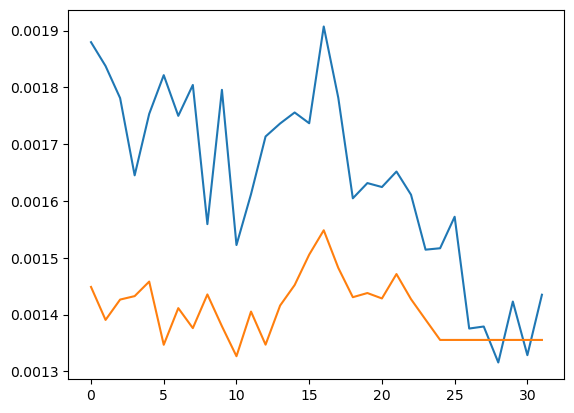

In [8]:
from matplotlib import pyplot as plt
plt.plot(attention_pred[0])
plt.plot(batch['obs'][0, :, -1])

In [9]:
torch.save(model.state_dict(), os.path.join(lowdim_dataset_dir, f"transformer_attention_estimator_epoch={dataset_epoch}.pth"))

In [ ]:
# Now plot both true attention and predicted attention
import os

# zarr_path = os.path.expanduser('../data/robomimic/datasets/lift/ph/image_abs.hdf5.zarr.zip')
dataset_path = os.path.expanduser('../data/robomimic/datasets/can/ph/image_abs.hdf5')
# replay_buffer = ReplayBuffer.copy_from_path(zarr_path, keys=None)

# Define shape metadata
shape_meta = {
    'action': {
        'shape': [7]
    },
    'obs': {
        'object': {
            'shape': [14]
        },
        'agentview_image': {
            'shape': [3, 84, 84],
            'type': 'rgb'
        },
        'robot0_eef_pos': {
            'shape': [3]
        },
        'robot0_eef_quat': {
            'shape': [4]
        },
        'robot0_eye_in_hand_image': {
            'shape': [3, 84, 84],
            'type': 'rgb'
        },
        'robot0_gripper_qpos': {
            'shape': [2]
        }
    }
}

# Create dataset
image_dataset = RobomimicReplayImageDataset(
    dataset_path=dataset_path,
    shape_meta=shape_meta,
    horizon=2,
    pad_before=1,
    pad_after=1,
    rotation_rep='rotation_6d',
    seed=42,
    val_ratio=0.0,
    use_legacy_normalizer=False,
    use_cache=True
)

img_dataloader = DataLoader(image_dataset, batch_size=1, shuffle=False)
img_iterator = iter(img_dataloader)

display_dataloader = DataLoader(
    RobomimicReplayLowdimDataset(lowdim_dataset_path, horizon=horizon, pad_before=1, pad_after=horizon-1, obs_keys=['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos', 'spatial_attention'], abs_action=True, rotation_rep='rotation_6d', use_legacy_normalizer=False, seed=42, val_ratio=0.0, max_train_episodes=None),
    batch_size=1,
)w

assert len(display_dataloader) == len(img_dataloader)

Acquiring lock on cache.
Loading cached ReplayBuffer from Disk.
Loaded!


Loading hdf5 to ReplayBuffer: 100%|██████████| 200/200 [00:00<00:00, 821.59it/s]


  0%|          | 0/200 [00:22<?, ?it/s]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_0.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_0.mp4



  0%|          | 1/200 [00:22<1:15:29, 22.76s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_0.mp4


  0%|          | 1/200 [00:44<1:15:29, 22.76s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_1.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_1.mp4



  1%|          | 2/200 [00:44<1:13:51, 22.38s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_1.mp4


  1%|          | 2/200 [01:05<1:13:51, 22.38s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_2.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_2.mp4



  2%|▏         | 3/200 [01:05<1:11:10, 21.68s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_2.mp4


  2%|▏         | 3/200 [01:21<1:11:10, 21.68s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_3.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_3.mp4



  2%|▏         | 4/200 [01:21<1:03:45, 19.52s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_3.mp4


  2%|▏         | 4/200 [01:39<1:03:45, 19.52s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_4.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_4.mp4



  2%|▎         | 5/200 [01:39<1:01:03, 18.79s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_4.mp4


  2%|▎         | 5/200 [02:07<1:01:03, 18.79s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_5.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_5.mp4



  3%|▎         | 6/200 [02:07<1:11:10, 22.01s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_5.mp4


  3%|▎         | 6/200 [02:29<1:11:10, 22.01s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_6.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_6.mp4



  4%|▎         | 7/200 [02:29<1:10:33, 21.93s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_6.mp4


  4%|▎         | 7/200 [02:50<1:10:33, 21.93s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_7.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_7.mp4



  4%|▍         | 8/200 [02:50<1:09:28, 21.71s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_7.mp4


  4%|▍         | 8/200 [03:16<1:09:28, 21.71s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_8.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_8.mp4



  4%|▍         | 9/200 [03:16<1:13:02, 22.95s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_8.mp4


  4%|▍         | 9/200 [03:39<1:13:02, 22.95s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_9.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_9.mp4



  5%|▌         | 10/200 [03:39<1:12:55, 23.03s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_9.mp4


  5%|▌         | 10/200 [04:05<1:12:55, 23.03s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_10.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_10.mp4



  6%|▌         | 11/200 [04:05<1:15:37, 24.01s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_10.mp4


  6%|▌         | 11/200 [04:20<1:15:37, 24.01s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_11.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_11.mp4



  6%|▌         | 12/200 [04:20<1:06:35, 21.25s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_11.mp4


  6%|▌         | 12/200 [04:41<1:06:35, 21.25s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_12.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_12.mp4



  6%|▋         | 13/200 [04:42<1:06:19, 21.28s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_12.mp4


  6%|▋         | 13/200 [05:07<1:06:19, 21.28s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_13.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_13.mp4



  7%|▋         | 14/200 [05:08<1:10:24, 22.71s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_13.mp4


  7%|▋         | 14/200 [05:28<1:10:24, 22.71s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_14.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_14.mp4



  8%|▊         | 15/200 [05:28<1:08:07, 22.09s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_14.mp4


  8%|▊         | 15/200 [05:43<1:08:07, 22.09s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_15.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_15.mp4



  8%|▊         | 16/200 [05:43<1:01:13, 19.97s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_15.mp4


  8%|▊         | 16/200 [06:12<1:01:13, 19.97s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_16.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_16.mp4



  8%|▊         | 17/200 [06:12<1:08:59, 22.62s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_16.mp4


  8%|▊         | 17/200 [06:31<1:08:59, 22.62s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_17.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_17.mp4



  9%|▉         | 18/200 [06:31<1:05:09, 21.48s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_17.mp4


  9%|▉         | 18/200 [06:46<1:05:09, 21.48s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_18.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_18.mp4



 10%|▉         | 19/200 [06:46<58:49, 19.50s/it]  

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_18.mp4


 10%|▉         | 19/200 [07:05<58:49, 19.50s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_19.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_19.mp4



 10%|█         | 20/200 [07:06<58:41, 19.56s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_19.mp4


 10%|█         | 20/200 [07:20<58:41, 19.56s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_20.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_20.mp4



 10%|█         | 21/200 [07:20<53:40, 17.99s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_20.mp4


 10%|█         | 21/200 [07:36<53:40, 17.99s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_21.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_21.mp4



 11%|█         | 22/200 [07:36<52:08, 17.58s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_21.mp4


 11%|█         | 22/200 [07:54<52:08, 17.58s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_22.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_22.mp4



 12%|█▏        | 23/200 [07:54<51:45, 17.54s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_22.mp4


 12%|█▏        | 23/200 [08:25<51:45, 17.54s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_23.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_23.mp4



 12%|█▏        | 24/200 [08:26<1:03:56, 21.80s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_23.mp4


 12%|█▏        | 24/200 [08:44<1:03:56, 21.80s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_24.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_24.mp4



 12%|█▎        | 25/200 [08:45<1:01:14, 21.00s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_24.mp4


 12%|█▎        | 25/200 [09:11<1:01:14, 21.00s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_25.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_25.mp4



 13%|█▎        | 26/200 [09:12<1:05:56, 22.74s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_25.mp4


 13%|█▎        | 26/200 [09:32<1:05:56, 22.74s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_26.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_26.mp4



 14%|█▎        | 27/200 [09:32<1:03:28, 22.01s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_26.mp4


 14%|█▎        | 27/200 [09:56<1:03:28, 22.01s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_27.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_27.mp4



 14%|█▍        | 28/200 [09:57<1:05:25, 22.82s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_27.mp4


 14%|█▍        | 28/200 [10:27<1:05:25, 22.82s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_28.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_28.mp4



 14%|█▍        | 29/200 [10:27<1:11:54, 25.23s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_28.mp4


 14%|█▍        | 29/200 [10:46<1:11:54, 25.23s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_29.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_29.mp4



 15%|█▌        | 30/200 [10:46<1:05:50, 23.24s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_29.mp4


 15%|█▌        | 30/200 [11:12<1:05:50, 23.24s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_30.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_30.mp4



 16%|█▌        | 31/200 [11:12<1:07:35, 24.00s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_30.mp4


 16%|█▌        | 31/200 [11:27<1:07:35, 24.00s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_31.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_31.mp4



 16%|█▌        | 32/200 [11:27<59:44, 21.34s/it]  

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_31.mp4


 16%|█▌        | 32/200 [11:46<59:44, 21.34s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_32.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_32.mp4



 16%|█▋        | 33/200 [11:46<57:46, 20.76s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_32.mp4


 16%|█▋        | 33/200 [12:07<57:46, 20.76s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_33.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_33.mp4



 17%|█▋        | 34/200 [12:08<57:48, 20.90s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_33.mp4


 17%|█▋        | 34/200 [12:26<57:48, 20.90s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_34.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_34.mp4



 18%|█▊        | 35/200 [12:26<55:36, 20.22s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_34.mp4


 18%|█▊        | 35/200 [12:46<55:36, 20.22s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_35.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_35.mp4



 18%|█▊        | 36/200 [12:46<54:57, 20.11s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_35.mp4


 18%|█▊        | 36/200 [13:03<54:57, 20.11s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_36.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_36.mp4



 18%|█▊        | 37/200 [13:03<52:23, 19.28s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_36.mp4


 18%|█▊        | 37/200 [13:25<52:23, 19.28s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_37.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_37.mp4



 19%|█▉        | 38/200 [13:25<53:58, 19.99s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_37.mp4


 19%|█▉        | 38/200 [13:43<53:58, 19.99s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_38.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_38.mp4



 20%|█▉        | 39/200 [13:43<52:22, 19.52s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_38.mp4


 20%|█▉        | 39/200 [14:04<52:22, 19.52s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_39.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_39.mp4



 20%|██        | 40/200 [14:04<53:09, 19.93s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_39.mp4


 20%|██        | 40/200 [14:26<53:09, 19.93s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_40.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_40.mp4



 20%|██        | 41/200 [14:26<54:23, 20.52s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_40.mp4


 20%|██        | 41/200 [14:55<54:23, 20.52s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_41.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_41.mp4



 21%|██        | 42/200 [14:56<1:01:08, 23.22s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_41.mp4


 21%|██        | 42/200 [15:18<1:01:08, 23.22s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_42.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_42.mp4



 22%|██▏       | 43/200 [15:18<1:00:03, 22.95s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_42.mp4


 22%|██▏       | 43/200 [15:36<1:00:03, 22.95s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_43.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_43.mp4



 22%|██▏       | 44/200 [15:37<56:15, 21.64s/it]  

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_43.mp4


 22%|██▏       | 44/200 [16:00<56:15, 21.64s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_44.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_44.mp4



 22%|██▎       | 45/200 [16:00<57:24, 22.22s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_44.mp4


 22%|██▎       | 45/200 [16:26<57:24, 22.22s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_45.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_45.mp4



 23%|██▎       | 46/200 [16:26<59:51, 23.32s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_45.mp4


 23%|██▎       | 46/200 [16:44<59:51, 23.32s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_46.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_46.mp4



 24%|██▎       | 47/200 [16:45<55:46, 21.87s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_46.mp4


 24%|██▎       | 47/200 [17:11<55:46, 21.87s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_47.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_47.mp4



 24%|██▍       | 48/200 [17:11<58:52, 23.24s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_47.mp4


 24%|██▍       | 48/200 [17:31<58:52, 23.24s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_48.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_48.mp4



 24%|██▍       | 49/200 [17:32<56:26, 22.43s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_48.mp4


 24%|██▍       | 49/200 [17:50<56:26, 22.43s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_49.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_49.mp4



 25%|██▌       | 50/200 [17:50<52:55, 21.17s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_49.mp4


 25%|██▌       | 50/200 [18:10<52:55, 21.17s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_50.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_50.mp4



 26%|██▌       | 51/200 [18:10<51:51, 20.88s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_50.mp4


 26%|██▌       | 51/200 [18:31<51:51, 20.88s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_51.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_51.mp4



 26%|██▌       | 52/200 [18:31<51:41, 20.96s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_51.mp4


 26%|██▌       | 52/200 [18:54<51:41, 20.96s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_52.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_52.mp4



 26%|██▋       | 53/200 [18:54<52:43, 21.52s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_52.mp4


 26%|██▋       | 53/200 [19:15<52:43, 21.52s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_53.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_53.mp4



 27%|██▋       | 54/200 [19:15<52:13, 21.46s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_53.mp4


 27%|██▋       | 54/200 [19:34<52:13, 21.46s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_54.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_54.mp4



 28%|██▊       | 55/200 [19:34<50:05, 20.73s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_54.mp4


 28%|██▊       | 55/200 [19:51<50:05, 20.73s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_55.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_55.mp4



 28%|██▊       | 56/200 [19:51<46:49, 19.51s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_55.mp4


 28%|██▊       | 56/200 [20:08<46:49, 19.51s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_56.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_56.mp4



 28%|██▊       | 57/200 [20:08<44:31, 18.68s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_56.mp4


 28%|██▊       | 57/200 [20:31<44:31, 18.68s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_57.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_57.mp4



 29%|██▉       | 58/200 [20:31<47:27, 20.05s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_57.mp4


 29%|██▉       | 58/200 [20:56<47:27, 20.05s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_58.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_58.mp4



 30%|██▉       | 59/200 [20:56<50:45, 21.60s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_58.mp4


 30%|██▉       | 59/200 [21:16<50:45, 21.60s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_59.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_59.mp4



 30%|███       | 60/200 [21:17<49:38, 21.28s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_59.mp4


 30%|███       | 60/200 [21:32<49:38, 21.28s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_60.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_60.mp4



 30%|███       | 61/200 [21:32<45:21, 19.58s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_60.mp4


 30%|███       | 61/200 [21:53<45:21, 19.58s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_61.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_61.mp4



 31%|███       | 62/200 [21:53<45:49, 19.93s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_61.mp4


 31%|███       | 62/200 [22:17<45:49, 19.93s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_62.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_62.mp4



 32%|███▏      | 63/200 [22:17<48:25, 21.21s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_62.mp4


 32%|███▏      | 63/200 [22:44<48:25, 21.21s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_63.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_63.mp4



 32%|███▏      | 64/200 [22:45<52:08, 23.00s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_63.mp4


 32%|███▏      | 64/200 [23:02<52:08, 23.00s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_64.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_64.mp4



 32%|███▎      | 65/200 [23:02<48:00, 21.34s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_64.mp4


 32%|███▎      | 65/200 [23:22<48:00, 21.34s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_65.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_65.mp4



 33%|███▎      | 66/200 [23:23<47:14, 21.15s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_65.mp4


 33%|███▎      | 66/200 [23:49<47:14, 21.15s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_66.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_66.mp4



 34%|███▎      | 67/200 [23:49<50:31, 22.80s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_66.mp4


 34%|███▎      | 67/200 [24:17<50:31, 22.80s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_67.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_67.mp4



 34%|███▍      | 68/200 [24:17<53:25, 24.29s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_67.mp4


 34%|███▍      | 68/200 [24:34<53:25, 24.29s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_68.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_68.mp4



 34%|███▍      | 69/200 [24:35<48:32, 22.23s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_68.mp4


 34%|███▍      | 69/200 [24:59<48:32, 22.23s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_69.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_69.mp4



 35%|███▌      | 70/200 [25:00<50:03, 23.10s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_69.mp4


 35%|███▌      | 70/200 [25:16<50:03, 23.10s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_70.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_70.mp4



 36%|███▌      | 71/200 [25:17<45:44, 21.27s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_70.mp4


 36%|███▌      | 71/200 [25:35<45:44, 21.27s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_71.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_71.mp4



 36%|███▌      | 72/200 [25:36<43:56, 20.60s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_71.mp4


 36%|███▌      | 72/200 [25:49<43:56, 20.60s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_72.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_72.mp4



 36%|███▋      | 73/200 [25:50<39:27, 18.65s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_72.mp4


 36%|███▋      | 73/200 [26:13<39:27, 18.65s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_73.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_73.mp4



 37%|███▋      | 74/200 [26:13<41:58, 19.99s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_73.mp4


 37%|███▋      | 74/200 [26:34<41:58, 19.99s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_74.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_74.mp4



 38%|███▊      | 75/200 [26:34<42:22, 20.34s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_74.mp4


 38%|███▊      | 75/200 [26:51<42:22, 20.34s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_75.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_75.mp4



 38%|███▊      | 76/200 [26:52<40:16, 19.49s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_75.mp4


 38%|███▊      | 76/200 [27:08<40:16, 19.49s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_76.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_76.mp4



 38%|███▊      | 77/200 [27:08<38:05, 18.58s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_76.mp4


 38%|███▊      | 77/200 [27:31<38:05, 18.58s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_77.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_77.mp4



 39%|███▉      | 78/200 [27:31<40:37, 19.98s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_77.mp4


 39%|███▉      | 78/200 [27:47<40:37, 19.98s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_78.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_78.mp4



 40%|███▉      | 79/200 [27:47<37:56, 18.81s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_78.mp4


 40%|███▉      | 79/200 [28:01<37:56, 18.81s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_79.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_79.mp4



 40%|████      | 80/200 [28:02<34:52, 17.44s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_79.mp4


 40%|████      | 80/200 [28:21<34:52, 17.44s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_80.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_80.mp4



 40%|████      | 81/200 [28:21<35:47, 18.05s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_80.mp4


 40%|████      | 81/200 [28:56<35:47, 18.05s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_81.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_81.mp4



 41%|████      | 82/200 [28:56<45:35, 23.18s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_81.mp4


 41%|████      | 82/200 [29:11<45:35, 23.18s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_82.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_82.mp4



 42%|████▏     | 83/200 [29:11<40:21, 20.70s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_82.mp4


 42%|████▏     | 83/200 [29:30<40:21, 20.70s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_83.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_83.mp4



 42%|████▏     | 84/200 [29:30<39:06, 20.22s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_83.mp4


 42%|████▏     | 84/200 [29:48<39:06, 20.22s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_84.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_84.mp4



 42%|████▎     | 85/200 [29:48<37:35, 19.61s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_84.mp4


 42%|████▎     | 85/200 [30:10<37:35, 19.61s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_85.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_85.mp4



 43%|████▎     | 86/200 [30:10<38:18, 20.17s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_85.mp4


 43%|████▎     | 86/200 [30:35<38:18, 20.17s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_86.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_86.mp4



 44%|████▎     | 87/200 [30:35<40:51, 21.69s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_86.mp4


 44%|████▎     | 87/200 [30:48<40:51, 21.69s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_87.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_87.mp4



 44%|████▍     | 88/200 [30:48<35:38, 19.09s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_87.mp4


 44%|████▍     | 88/200 [31:09<35:38, 19.09s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_88.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_88.mp4



 44%|████▍     | 89/200 [31:10<36:36, 19.79s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_88.mp4


 44%|████▍     | 89/200 [31:31<36:36, 19.79s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_89.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_89.mp4



 45%|████▌     | 90/200 [31:31<37:19, 20.36s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_89.mp4


 45%|████▌     | 90/200 [31:58<37:19, 20.36s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_90.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_90.mp4



 46%|████▌     | 91/200 [31:59<40:47, 22.45s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_90.mp4


 46%|████▌     | 91/200 [32:19<40:47, 22.45s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_91.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_91.mp4



 46%|████▌     | 92/200 [32:20<39:38, 22.02s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_91.mp4


 46%|████▌     | 92/200 [32:39<39:38, 22.02s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_92.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_92.mp4



 46%|████▋     | 93/200 [32:39<37:56, 21.28s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_92.mp4


 46%|████▋     | 93/200 [32:54<37:56, 21.28s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_93.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_93.mp4



 47%|████▋     | 94/200 [32:54<34:22, 19.45s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_93.mp4


 47%|████▋     | 94/200 [33:20<34:22, 19.45s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_94.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_94.mp4



 48%|████▊     | 95/200 [33:20<37:19, 21.33s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_94.mp4


 48%|████▊     | 95/200 [33:44<37:19, 21.33s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_95.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_95.mp4



 48%|████▊     | 96/200 [33:44<38:15, 22.07s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_95.mp4


 48%|████▊     | 96/200 [34:14<38:15, 22.07s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_96.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_96.mp4



 48%|████▊     | 97/200 [34:14<42:13, 24.60s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_96.mp4


 48%|████▊     | 97/200 [34:32<42:13, 24.60s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_97.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_97.mp4



 49%|████▉     | 98/200 [34:32<38:24, 22.59s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_97.mp4


 49%|████▉     | 98/200 [34:51<38:24, 22.59s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_98.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_98.mp4



 50%|████▉     | 99/200 [34:52<36:24, 21.63s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_98.mp4


 50%|████▉     | 99/200 [35:12<36:24, 21.63s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_99.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_99.mp4



 50%|█████     | 100/200 [35:12<35:28, 21.29s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_99.mp4


 50%|█████     | 100/200 [35:34<35:28, 21.29s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_100.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_100.mp4



 50%|█████     | 101/200 [35:34<35:29, 21.51s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_100.mp4


 50%|█████     | 101/200 [36:01<35:29, 21.51s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_101.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_101.mp4



 51%|█████     | 102/200 [36:01<37:55, 23.22s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_101.mp4


 51%|█████     | 102/200 [36:19<37:55, 23.22s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_102.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_102.mp4



 52%|█████▏    | 103/200 [36:20<35:08, 21.74s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_102.mp4


 52%|█████▏    | 103/200 [36:35<35:08, 21.74s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_103.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_103.mp4



 52%|█████▏    | 104/200 [36:35<31:43, 19.83s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_103.mp4


 52%|█████▏    | 104/200 [36:58<31:43, 19.83s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_104.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_104.mp4



 52%|█████▎    | 105/200 [36:58<32:48, 20.73s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_104.mp4


 52%|█████▎    | 105/200 [37:24<32:48, 20.73s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_105.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_105.mp4



 53%|█████▎    | 106/200 [37:24<35:07, 22.42s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_105.mp4


 53%|█████▎    | 106/200 [37:47<35:07, 22.42s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_106.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_106.mp4



 54%|█████▎    | 107/200 [37:47<35:08, 22.67s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_106.mp4


 54%|█████▎    | 107/200 [38:08<35:08, 22.67s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_107.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_107.mp4



 54%|█████▍    | 108/200 [38:08<33:45, 22.02s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_107.mp4


 54%|█████▍    | 108/200 [38:22<33:45, 22.02s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_108.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_108.mp4



 55%|█████▍    | 109/200 [38:23<30:07, 19.86s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_108.mp4


 55%|█████▍    | 109/200 [38:47<30:07, 19.86s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_109.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_109.mp4



 55%|█████▌    | 110/200 [38:47<31:41, 21.13s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_109.mp4


 55%|█████▌    | 110/200 [39:11<31:41, 21.13s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_110.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_110.mp4



 56%|█████▌    | 111/200 [39:11<32:50, 22.14s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_110.mp4


 56%|█████▌    | 111/200 [39:29<32:50, 22.14s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_111.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_111.mp4



 56%|█████▌    | 112/200 [39:30<30:47, 20.99s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_111.mp4


 56%|█████▌    | 112/200 [39:48<30:47, 20.99s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_112.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_112.mp4



 56%|█████▋    | 113/200 [39:48<29:27, 20.31s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_112.mp4


 56%|█████▋    | 113/200 [40:09<29:27, 20.31s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_113.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_113.mp4



 57%|█████▋    | 114/200 [40:10<29:31, 20.59s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_113.mp4


 57%|█████▋    | 114/200 [40:34<29:31, 20.59s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_114.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_114.mp4



 57%|█████▊    | 115/200 [40:34<30:45, 21.71s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_114.mp4


 57%|█████▊    | 115/200 [40:52<30:45, 21.71s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_115.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_115.mp4



 58%|█████▊    | 116/200 [40:52<28:50, 20.60s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_115.mp4


 58%|█████▊    | 116/200 [41:03<28:50, 20.60s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_116.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_116.mp4



 58%|█████▊    | 117/200 [41:04<24:46, 17.91s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_116.mp4


 58%|█████▊    | 117/200 [41:29<24:46, 17.91s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_117.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_117.mp4



 59%|█████▉    | 118/200 [41:30<27:48, 20.35s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_117.mp4


 59%|█████▉    | 118/200 [41:42<27:48, 20.35s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_118.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_118.mp4



 60%|█████▉    | 119/200 [41:42<24:15, 17.97s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_118.mp4


 60%|█████▉    | 119/200 [42:05<24:15, 17.97s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_119.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_119.mp4



 60%|██████    | 120/200 [42:05<26:07, 19.59s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_119.mp4


 60%|██████    | 120/200 [42:22<26:07, 19.59s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_120.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_120.mp4



 60%|██████    | 121/200 [42:23<24:50, 18.87s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_120.mp4


 60%|██████    | 121/200 [42:37<24:50, 18.87s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_121.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_121.mp4



 61%|██████    | 122/200 [42:38<23:02, 17.72s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_121.mp4


 61%|██████    | 122/200 [43:02<23:02, 17.72s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_122.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_122.mp4



 62%|██████▏   | 123/200 [43:03<25:31, 19.89s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_122.mp4


 62%|██████▏   | 123/200 [43:35<25:31, 19.89s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_123.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_123.mp4



 62%|██████▏   | 124/200 [43:35<30:02, 23.72s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_123.mp4


 62%|██████▏   | 124/200 [44:01<30:02, 23.72s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_124.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_124.mp4



 62%|██████▎   | 125/200 [44:01<30:34, 24.46s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_124.mp4


 62%|██████▎   | 125/200 [44:28<30:34, 24.46s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_125.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_125.mp4



 63%|██████▎   | 126/200 [44:29<31:11, 25.29s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_125.mp4


 63%|██████▎   | 126/200 [44:50<31:11, 25.29s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_126.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_126.mp4



 64%|██████▎   | 127/200 [44:51<29:36, 24.34s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_126.mp4


 64%|██████▎   | 127/200 [45:08<29:36, 24.34s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_127.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_127.mp4



 64%|██████▍   | 128/200 [45:08<26:38, 22.21s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_127.mp4


 64%|██████▍   | 128/200 [45:26<26:38, 22.21s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_128.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_128.mp4



 64%|██████▍   | 129/200 [45:26<24:54, 21.05s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_128.mp4


 64%|██████▍   | 129/200 [45:47<24:54, 21.05s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_129.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_129.mp4



 65%|██████▌   | 130/200 [45:47<24:31, 21.02s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_129.mp4


 65%|██████▌   | 130/200 [46:15<24:31, 21.02s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_130.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_130.mp4



 66%|██████▌   | 131/200 [46:16<26:45, 23.27s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_130.mp4


 66%|██████▌   | 131/200 [46:41<26:45, 23.27s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_131.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_131.mp4



 66%|██████▌   | 132/200 [46:41<26:59, 23.82s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_131.mp4


 66%|██████▌   | 132/200 [47:02<26:59, 23.82s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_132.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_132.mp4



 66%|██████▋   | 133/200 [47:02<25:43, 23.04s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_132.mp4


 66%|██████▋   | 133/200 [47:19<25:43, 23.04s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_133.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_133.mp4



 67%|██████▋   | 134/200 [47:20<23:29, 21.36s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_133.mp4


 67%|██████▋   | 134/200 [47:49<23:29, 21.36s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_134.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_134.mp4



 68%|██████▊   | 135/200 [47:49<25:51, 23.87s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_134.mp4


 68%|██████▊   | 135/200 [48:15<25:51, 23.87s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_135.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_135.mp4



 68%|██████▊   | 136/200 [48:15<26:09, 24.53s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_135.mp4


 68%|██████▊   | 136/200 [48:34<26:09, 24.53s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_136.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_136.mp4



 68%|██████▊   | 137/200 [48:35<24:07, 22.98s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_136.mp4


 68%|██████▊   | 137/200 [49:00<24:07, 22.98s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_137.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_137.mp4



 69%|██████▉   | 138/200 [49:01<24:40, 23.88s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_137.mp4


 69%|██████▉   | 138/200 [49:17<24:40, 23.88s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_138.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_138.mp4



 70%|██████▉   | 139/200 [49:18<22:05, 21.74s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_138.mp4


 70%|██████▉   | 139/200 [49:41<22:05, 21.74s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_139.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_139.mp4



 70%|███████   | 140/200 [49:42<22:26, 22.45s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_139.mp4


 70%|███████   | 140/200 [49:57<22:26, 22.45s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_140.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_140.mp4



 70%|███████   | 141/200 [49:57<20:05, 20.43s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_140.mp4


 70%|███████   | 141/200 [50:24<20:05, 20.43s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_141.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_141.mp4



 71%|███████   | 142/200 [50:24<21:41, 22.43s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_141.mp4


 71%|███████   | 142/200 [50:54<21:41, 22.43s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_142.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_142.mp4



 72%|███████▏  | 143/200 [50:54<23:24, 24.65s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_142.mp4


 72%|███████▏  | 143/200 [51:23<23:24, 24.65s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_143.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_143.mp4



 72%|███████▏  | 144/200 [51:23<24:15, 26.00s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_143.mp4


 72%|███████▏  | 144/200 [51:42<24:15, 26.00s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_144.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_144.mp4



 72%|███████▎  | 145/200 [51:43<22:01, 24.03s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_144.mp4


 72%|███████▎  | 145/200 [52:14<22:01, 24.03s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_145.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_145.mp4



 73%|███████▎  | 146/200 [52:15<23:45, 26.41s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_145.mp4


 73%|███████▎  | 146/200 [52:43<23:45, 26.41s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_146.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_146.mp4



 74%|███████▎  | 147/200 [52:44<23:57, 27.13s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_146.mp4


 74%|███████▎  | 147/200 [53:06<23:57, 27.13s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_147.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_147.mp4



 74%|███████▍  | 148/200 [53:06<22:23, 25.84s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_147.mp4


 74%|███████▍  | 148/200 [53:28<22:23, 25.84s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_148.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_148.mp4



 74%|███████▍  | 149/200 [53:29<21:00, 24.71s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_148.mp4


 74%|███████▍  | 149/200 [53:57<21:00, 24.71s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_149.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_149.mp4



 75%|███████▌  | 150/200 [53:57<21:39, 25.99s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_149.mp4


 75%|███████▌  | 150/200 [54:22<21:39, 25.99s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_150.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_150.mp4



 76%|███████▌  | 151/200 [54:22<20:56, 25.64s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_150.mp4


 76%|███████▌  | 151/200 [54:49<20:56, 25.64s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_151.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_151.mp4



 76%|███████▌  | 152/200 [54:49<20:50, 26.06s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_151.mp4


 76%|███████▌  | 152/200 [55:12<20:50, 26.06s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_152.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_152.mp4



 76%|███████▋  | 153/200 [55:12<19:35, 25.00s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_152.mp4


 76%|███████▋  | 153/200 [55:30<19:35, 25.00s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_153.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_153.mp4



 77%|███████▋  | 154/200 [55:30<17:41, 23.08s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_153.mp4


 77%|███████▋  | 154/200 [56:05<17:41, 23.08s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_154.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_154.mp4



 78%|███████▊  | 155/200 [56:06<20:00, 26.67s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_154.mp4


 78%|███████▊  | 155/200 [56:37<20:00, 26.67s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_155.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_155.mp4



 78%|███████▊  | 156/200 [56:38<20:48, 28.37s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_155.mp4


 78%|███████▊  | 156/200 [57:02<20:48, 28.37s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_156.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_156.mp4



 78%|███████▊  | 157/200 [57:02<19:28, 27.17s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_156.mp4


 78%|███████▊  | 157/200 [57:25<19:28, 27.17s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_157.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_157.mp4



 79%|███████▉  | 158/200 [57:25<18:04, 25.82s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_157.mp4


 79%|███████▉  | 158/200 [57:48<18:04, 25.82s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_158.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_158.mp4



 80%|███████▉  | 159/200 [57:49<17:12, 25.19s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_158.mp4


 80%|███████▉  | 159/200 [58:06<17:12, 25.19s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_159.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_159.mp4



 80%|████████  | 160/200 [58:06<15:11, 22.80s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_159.mp4


 80%|████████  | 160/200 [58:25<15:11, 22.80s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_160.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_160.mp4



 80%|████████  | 161/200 [58:25<14:10, 21.82s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_160.mp4


 80%|████████  | 161/200 [58:48<14:10, 21.82s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_161.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_161.mp4



 81%|████████  | 162/200 [58:48<14:00, 22.11s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_161.mp4


 81%|████████  | 162/200 [59:15<14:00, 22.11s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_162.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_162.mp4



 82%|████████▏ | 163/200 [59:15<14:34, 23.64s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_162.mp4


 82%|████████▏ | 163/200 [59:45<14:34, 23.64s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_163.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_163.mp4



 82%|████████▏ | 164/200 [59:46<15:22, 25.61s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_163.mp4


 82%|████████▏ | 164/200 [1:00:05<15:22, 25.61s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_164.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_164.mp4



 82%|████████▎ | 165/200 [1:00:05<13:50, 23.74s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_164.mp4


 82%|████████▎ | 165/200 [1:00:26<13:50, 23.74s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_165.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_165.mp4



 83%|████████▎ | 166/200 [1:00:27<13:06, 23.13s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_165.mp4


 83%|████████▎ | 166/200 [1:00:54<13:06, 23.13s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_166.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_166.mp4



 84%|████████▎ | 167/200 [1:00:54<13:25, 24.40s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_166.mp4


 84%|████████▎ | 167/200 [1:01:10<13:25, 24.40s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_167.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_167.mp4



 84%|████████▍ | 168/200 [1:01:10<11:40, 21.90s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_167.mp4


 84%|████████▍ | 168/200 [1:01:27<11:40, 21.90s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_168.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_168.mp4



 84%|████████▍ | 169/200 [1:01:27<10:34, 20.46s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_168.mp4


 84%|████████▍ | 169/200 [1:01:45<10:34, 20.46s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_169.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_169.mp4



 85%|████████▌ | 170/200 [1:01:45<09:48, 19.63s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_169.mp4


 85%|████████▌ | 170/200 [1:02:02<09:48, 19.63s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_170.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_170.mp4



 86%|████████▌ | 171/200 [1:02:02<09:09, 18.95s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_170.mp4


 86%|████████▌ | 171/200 [1:02:22<09:09, 18.95s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_171.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_171.mp4



 86%|████████▌ | 172/200 [1:02:22<08:57, 19.18s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_171.mp4


 86%|████████▌ | 172/200 [1:02:46<08:57, 19.18s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_172.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_172.mp4



 86%|████████▋ | 173/200 [1:02:47<09:23, 20.88s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_172.mp4


 86%|████████▋ | 173/200 [1:03:06<09:23, 20.88s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_173.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_173.mp4



 87%|████████▋ | 174/200 [1:03:06<08:50, 20.42s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_173.mp4


 87%|████████▋ | 174/200 [1:03:29<08:50, 20.42s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_174.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_174.mp4



 88%|████████▊ | 175/200 [1:03:29<08:48, 21.13s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_174.mp4


 88%|████████▊ | 175/200 [1:03:49<08:48, 21.13s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_175.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_175.mp4



 88%|████████▊ | 176/200 [1:03:50<08:24, 21.03s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_175.mp4


 88%|████████▊ | 176/200 [1:04:19<08:24, 21.03s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_176.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_176.mp4



 88%|████████▊ | 177/200 [1:04:19<08:59, 23.47s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_176.mp4


 88%|████████▊ | 177/200 [1:04:43<08:59, 23.47s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_177.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_177.mp4



 89%|████████▉ | 178/200 [1:04:44<08:44, 23.85s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_177.mp4


 89%|████████▉ | 178/200 [1:05:06<08:44, 23.85s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_178.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_178.mp4



 90%|████████▉ | 179/200 [1:05:06<08:12, 23.47s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_178.mp4


 90%|████████▉ | 179/200 [1:05:23<08:12, 23.47s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_179.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_179.mp4



 90%|█████████ | 180/200 [1:05:24<07:12, 21.62s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_179.mp4


 90%|█████████ | 180/200 [1:05:54<07:12, 21.62s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_180.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_180.mp4



 90%|█████████ | 181/200 [1:05:54<07:41, 24.30s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_180.mp4


 90%|█████████ | 181/200 [1:06:17<07:41, 24.30s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_181.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_181.mp4



 91%|█████████ | 182/200 [1:06:18<07:12, 24.04s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_181.mp4


 91%|█████████ | 182/200 [1:06:42<07:12, 24.04s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_182.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_182.mp4



 92%|█████████▏| 183/200 [1:06:42<06:53, 24.31s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_182.mp4


 92%|█████████▏| 183/200 [1:07:06<06:53, 24.31s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_183.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_183.mp4



 92%|█████████▏| 184/200 [1:07:06<06:25, 24.10s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_183.mp4


 92%|█████████▏| 184/200 [1:07:32<06:25, 24.10s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_184.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_184.mp4



 92%|█████████▎| 185/200 [1:07:33<06:12, 24.84s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_184.mp4


 92%|█████████▎| 185/200 [1:07:59<06:12, 24.84s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_185.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_185.mp4



 93%|█████████▎| 186/200 [1:07:59<05:54, 25.32s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_185.mp4


 93%|█████████▎| 186/200 [1:08:17<05:54, 25.32s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_186.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_186.mp4



 94%|█████████▎| 187/200 [1:08:17<05:02, 23.24s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_186.mp4


 94%|█████████▎| 187/200 [1:08:36<05:02, 23.24s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_187.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_187.mp4



 94%|█████████▍| 188/200 [1:08:37<04:24, 22.01s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_187.mp4


 94%|█████████▍| 188/200 [1:08:59<04:24, 22.01s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_188.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_188.mp4



 94%|█████████▍| 189/200 [1:08:59<04:04, 22.20s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_188.mp4


 94%|█████████▍| 189/200 [1:09:33<04:04, 22.20s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_189.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_189.mp4



 95%|█████████▌| 190/200 [1:09:34<04:19, 25.91s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_189.mp4


 95%|█████████▌| 190/200 [1:09:53<04:19, 25.91s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_190.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_190.mp4



 96%|█████████▌| 191/200 [1:09:54<03:36, 24.08s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_190.mp4


 96%|█████████▌| 191/200 [1:10:08<03:36, 24.08s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_191.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_191.mp4



 96%|█████████▌| 192/200 [1:10:09<02:50, 21.35s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_191.mp4


 96%|█████████▌| 192/200 [1:10:29<02:50, 21.35s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_192.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_192.mp4



 96%|█████████▋| 193/200 [1:10:30<02:28, 21.24s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_192.mp4


 96%|█████████▋| 193/200 [1:10:59<02:28, 21.24s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_193.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_193.mp4



 97%|█████████▋| 194/200 [1:10:59<02:22, 23.68s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_193.mp4


 97%|█████████▋| 194/200 [1:11:18<02:22, 23.68s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_194.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_194.mp4



 98%|█████████▊| 195/200 [1:11:18<01:51, 22.26s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_194.mp4


 98%|█████████▊| 195/200 [1:11:37<01:51, 22.26s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_195.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_195.mp4



 98%|█████████▊| 196/200 [1:11:38<01:26, 21.53s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_195.mp4


 98%|█████████▊| 196/200 [1:11:58<01:26, 21.53s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_196.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_196.mp4



 98%|█████████▊| 197/200 [1:11:59<01:04, 21.39s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_196.mp4


 98%|█████████▊| 197/200 [1:12:19<01:04, 21.39s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_197.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_197.mp4



 99%|█████████▉| 198/200 [1:12:20<00:42, 21.23s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_197.mp4


 99%|█████████▉| 198/200 [1:12:45<00:42, 21.23s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_198.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_198.mp4



100%|█████████▉| 199/200 [1:12:45<00:22, 22.42s/it]

Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_198.mp4


100%|█████████▉| 199/200 [1:13:00<00:22, 22.42s/it]

Moviepy - Building video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_199.mp4.
Moviepy - Writing video ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_199.mp4



100%|██████████| 200/200 [1:13:00<00:00, 21.90s/it]


Moviepy - Done !
Moviepy - video ready ../outputs/can_ph_lowdim_reproduction/2025.04.24_18.13.14_train_diffusion_unet_lowdim_can_lowdim_cnn_32/checkpoints/videos_with_spatial_attention_validate_epoch=200/episode_199.mp4


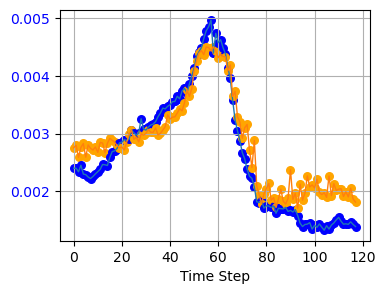

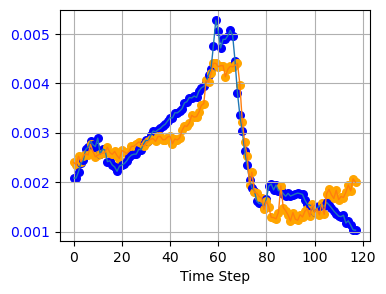

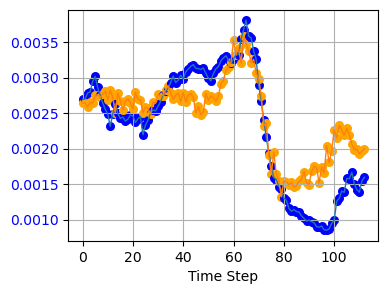

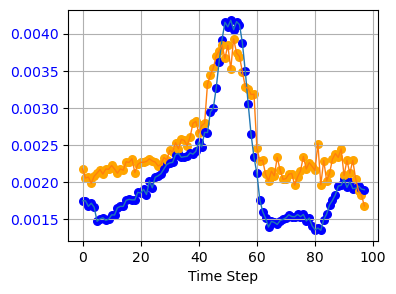

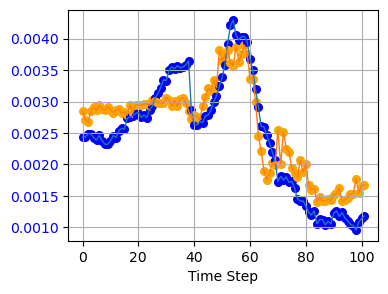

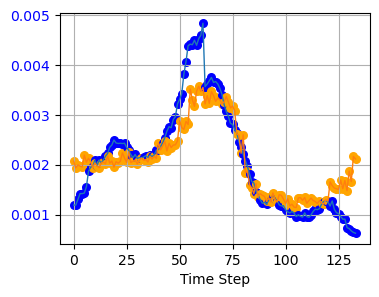

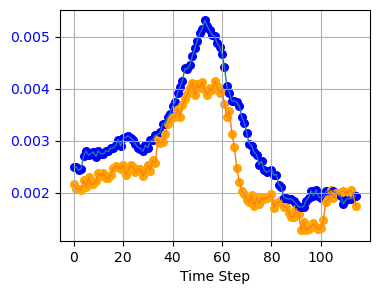

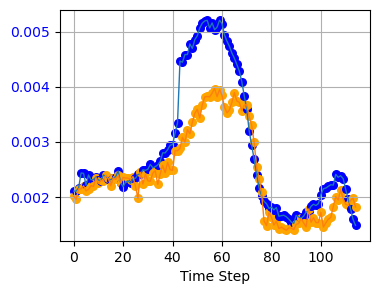

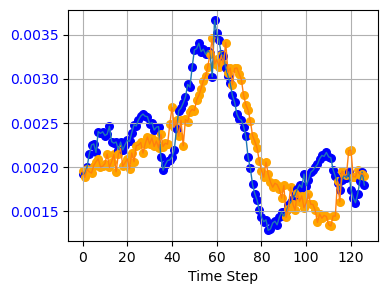

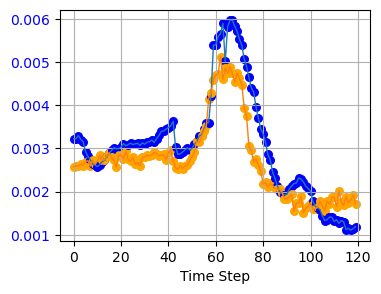

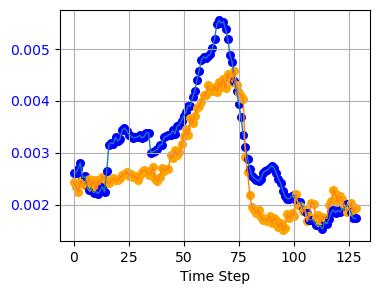

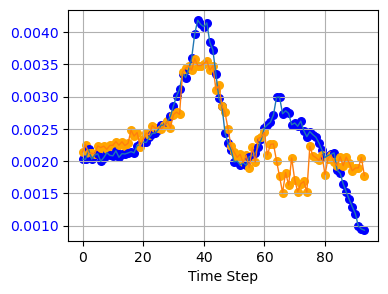

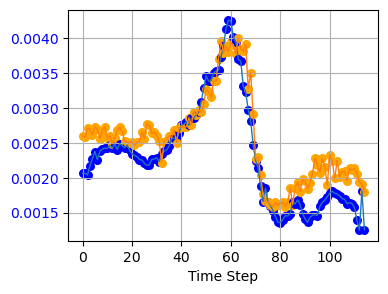

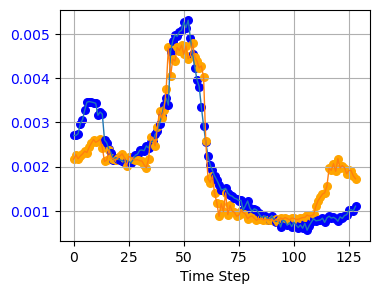

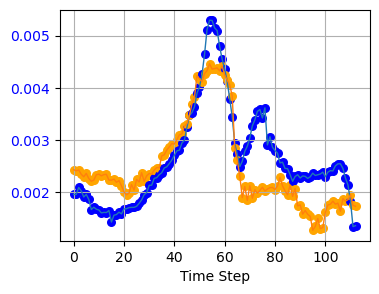

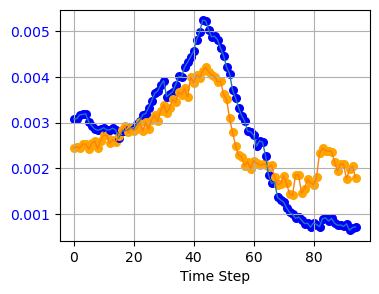

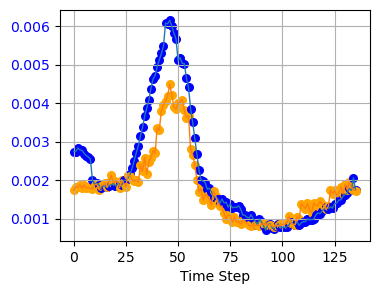

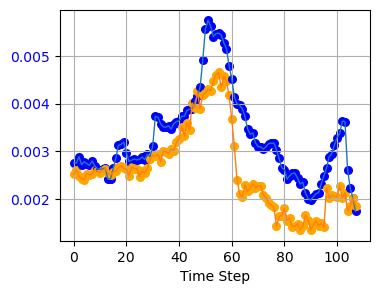

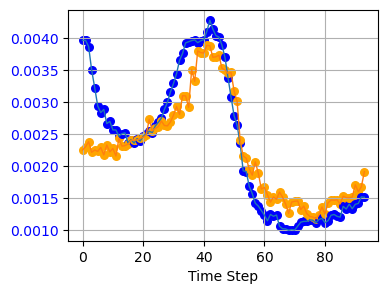

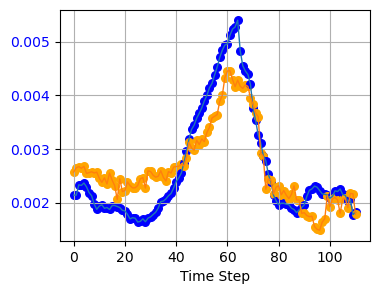

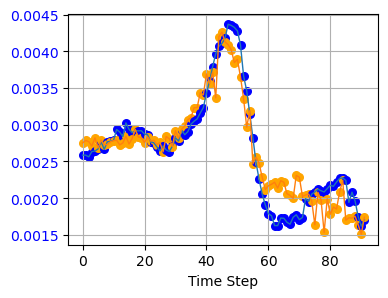

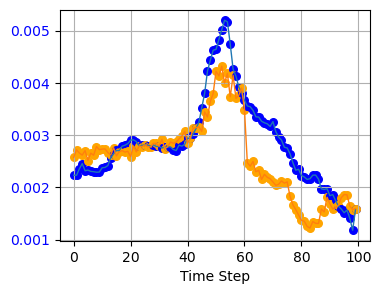

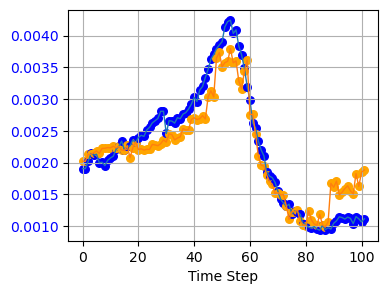

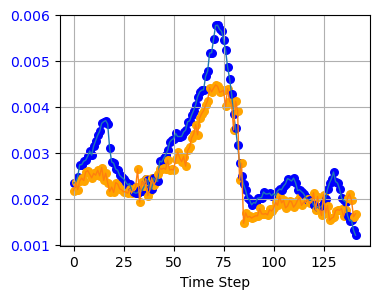

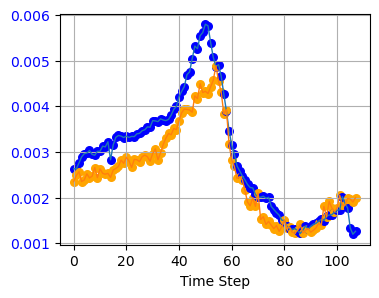

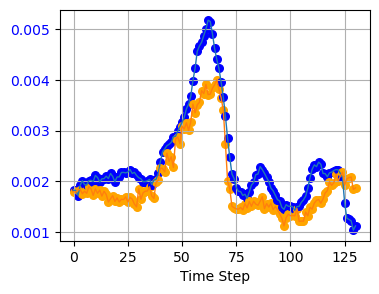

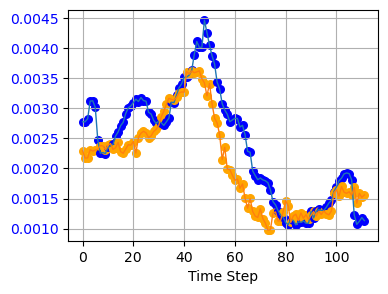

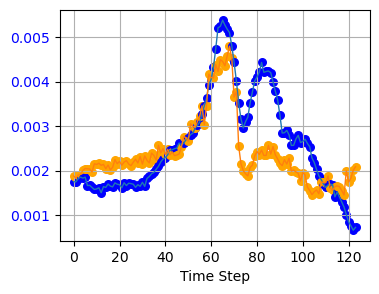

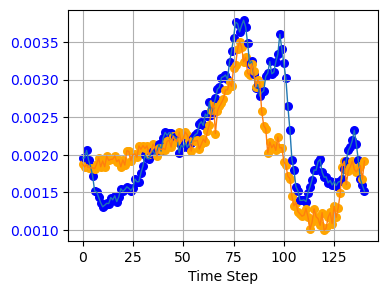

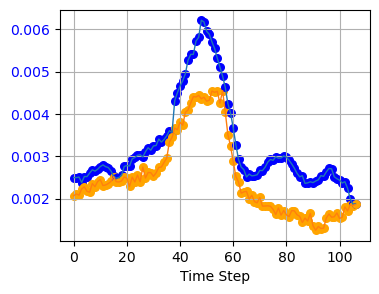

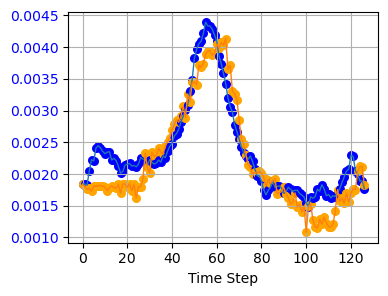

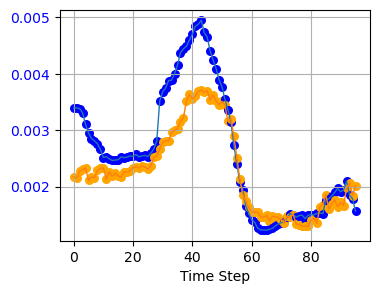

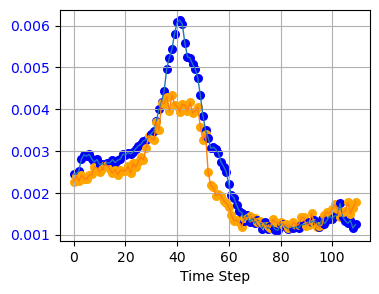

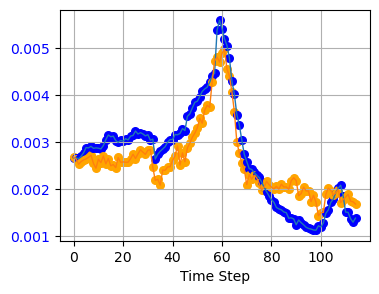

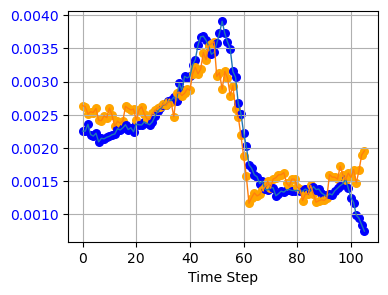

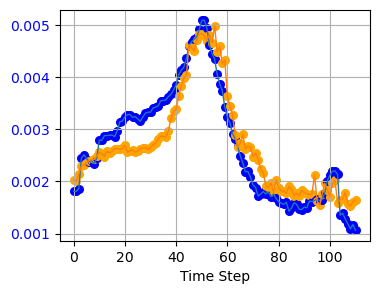

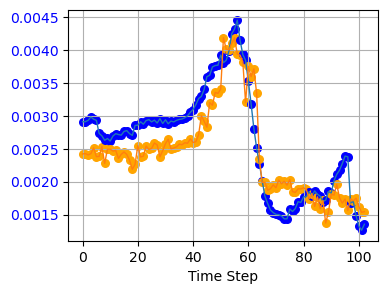

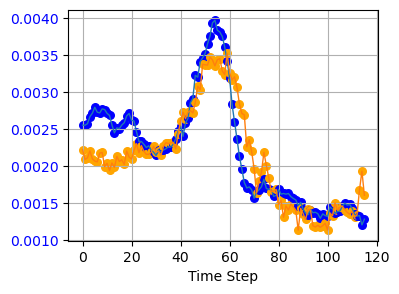

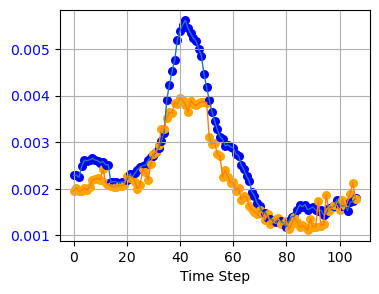

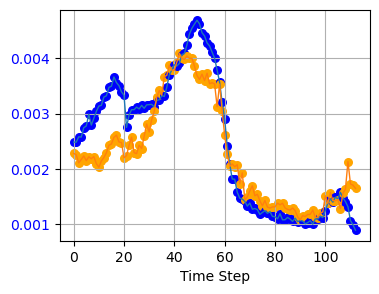

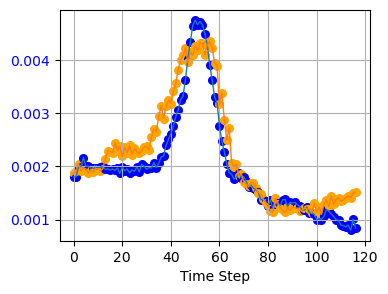

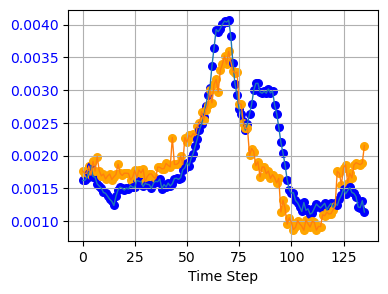

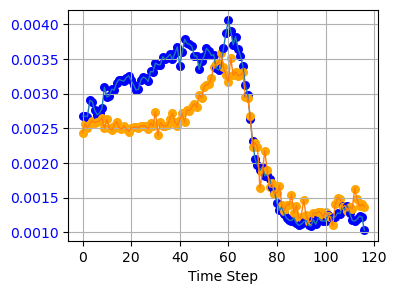

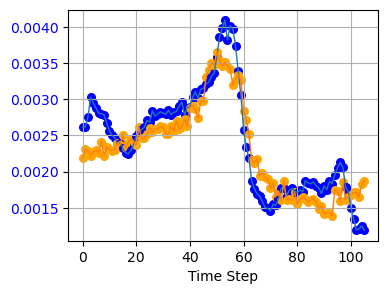

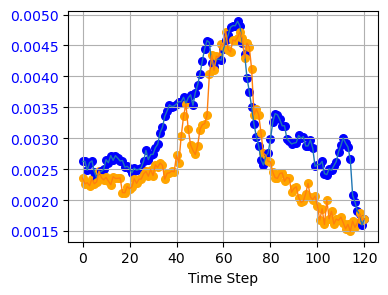

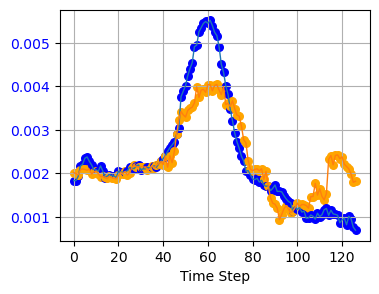

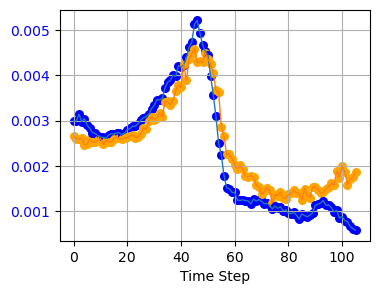

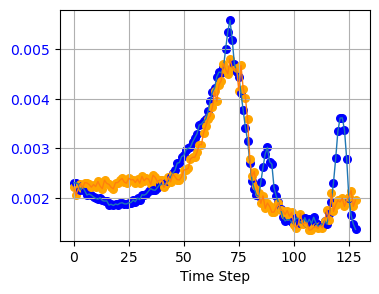

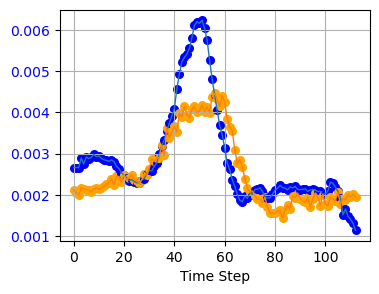

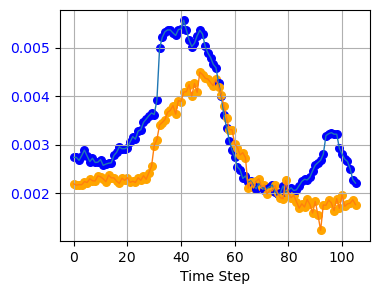

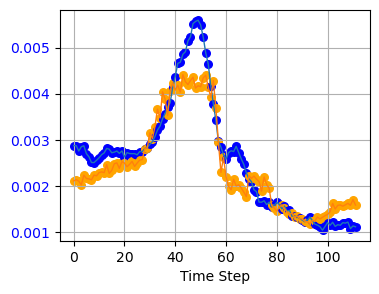

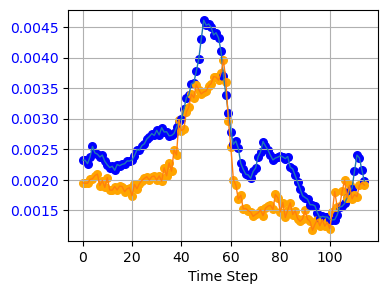

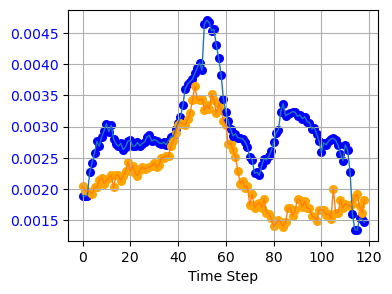

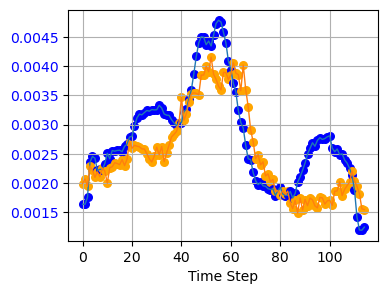

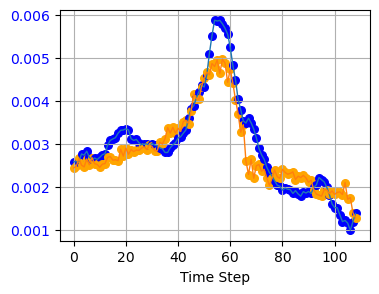

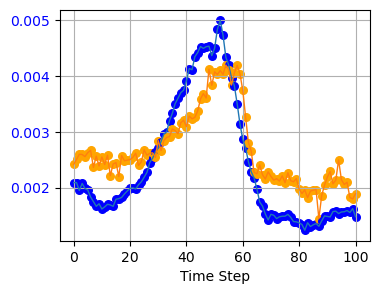

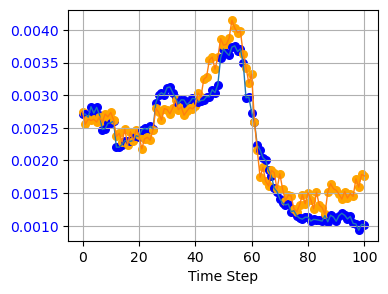

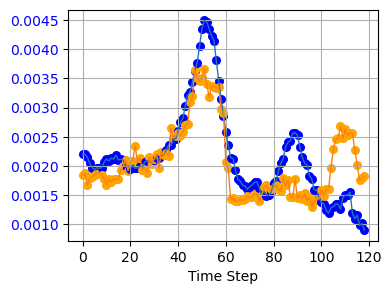

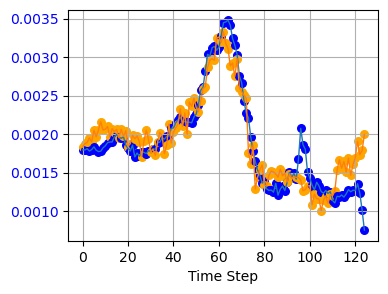

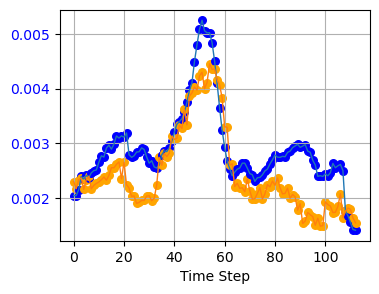

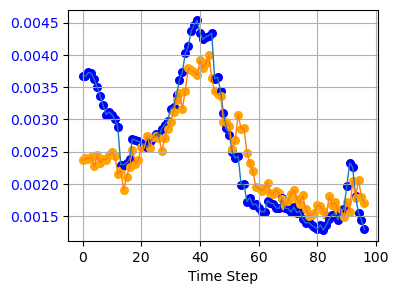

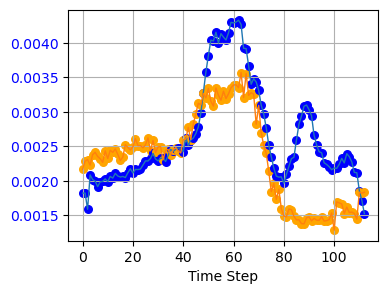

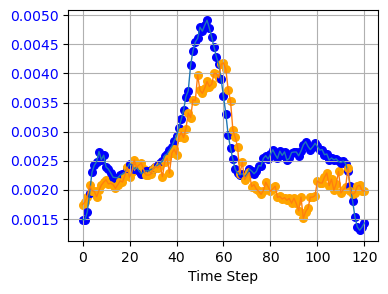

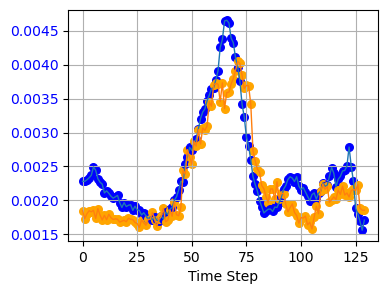

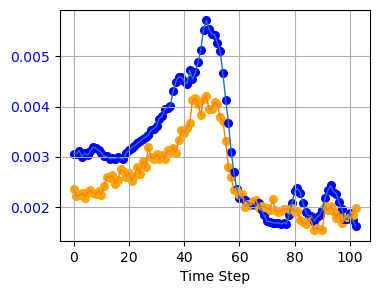

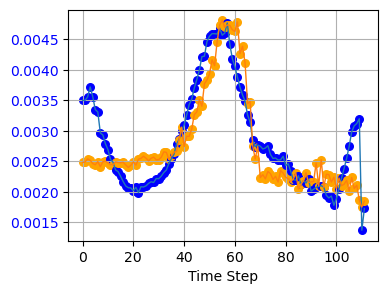

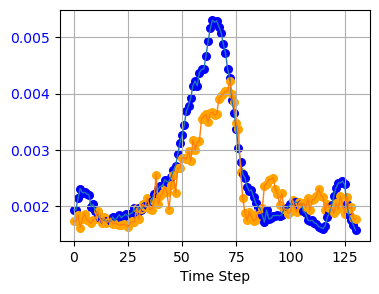

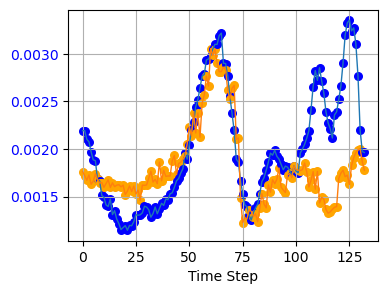

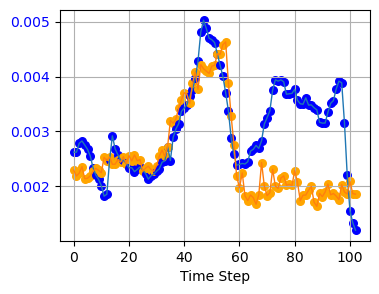

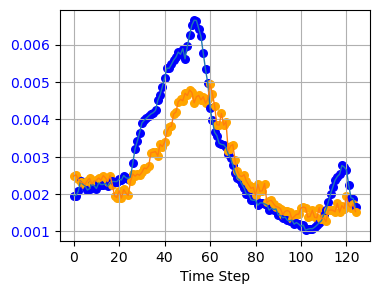

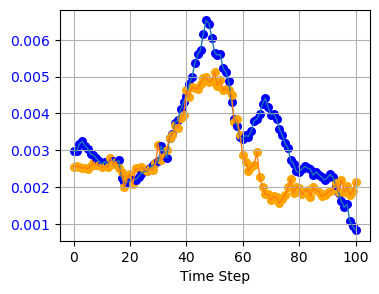

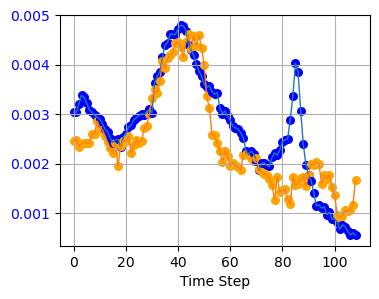

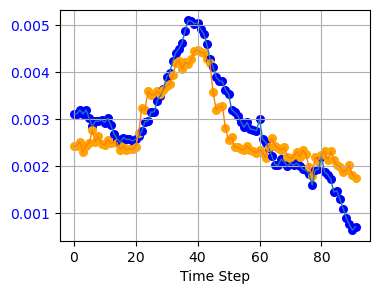

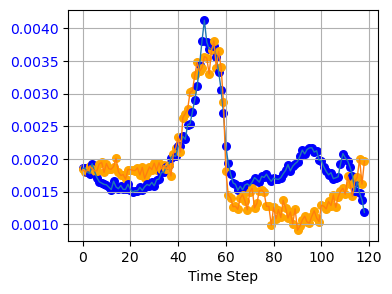

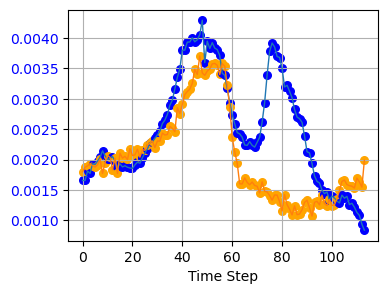

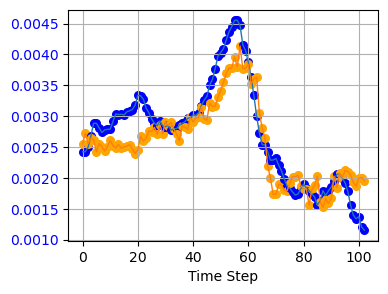

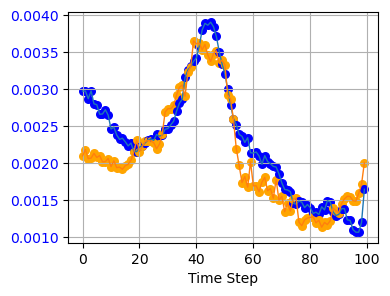

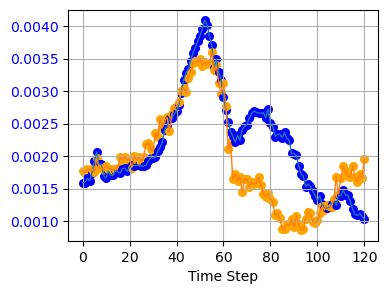

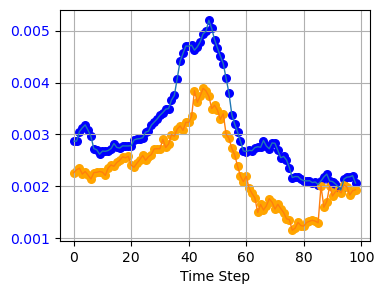

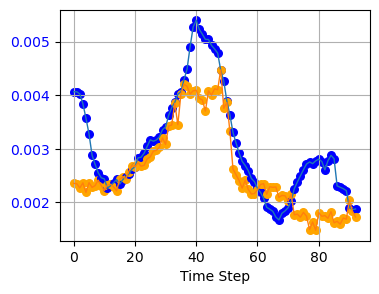

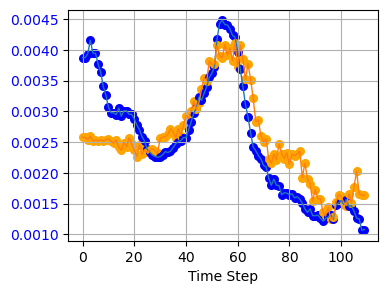

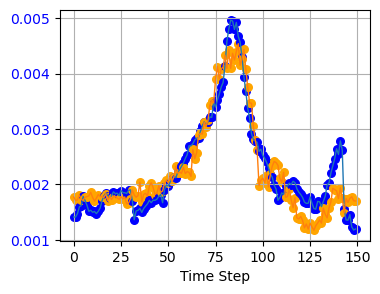

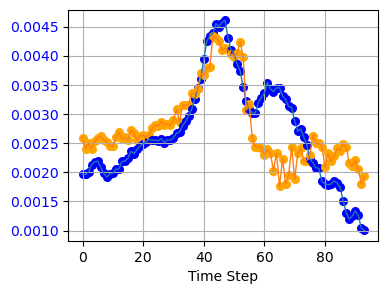

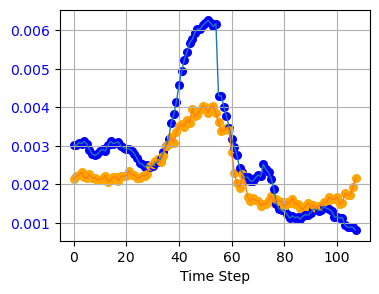

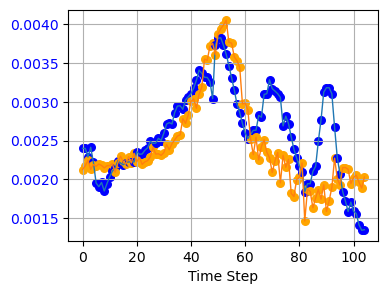

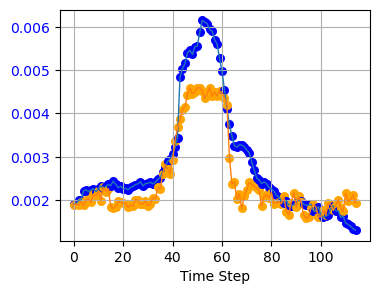

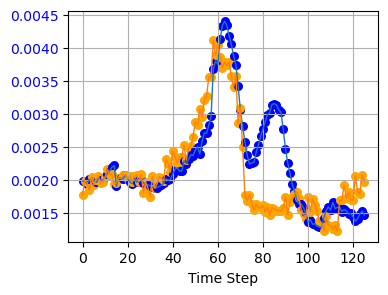

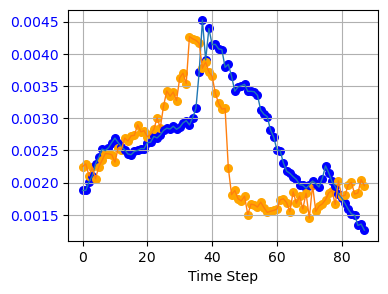

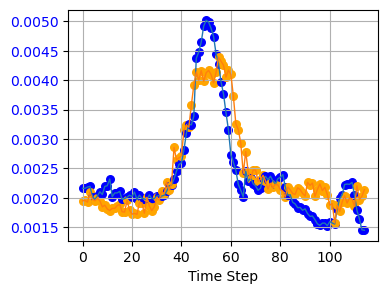

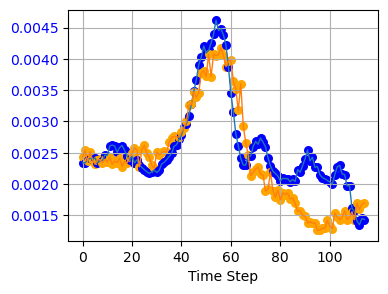

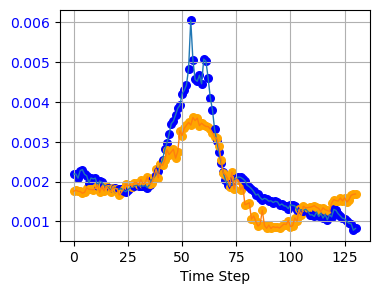

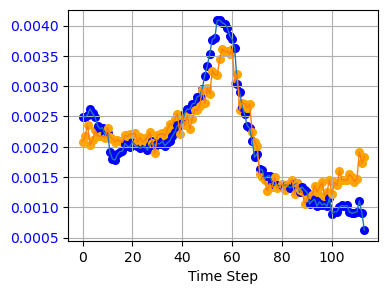

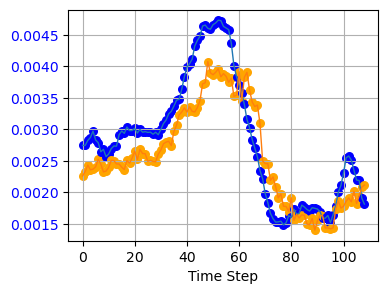

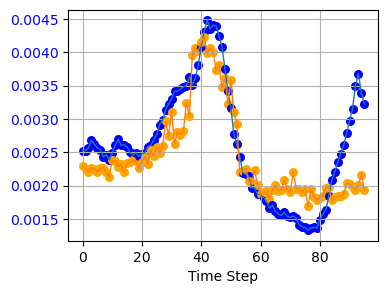

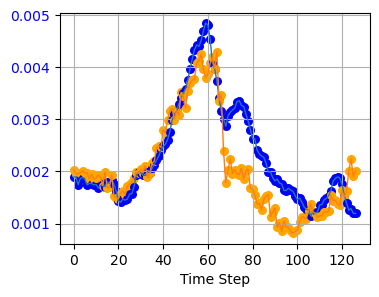

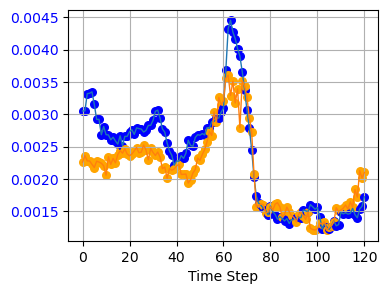

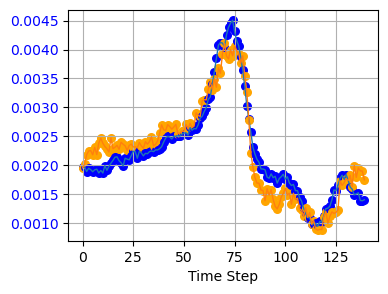

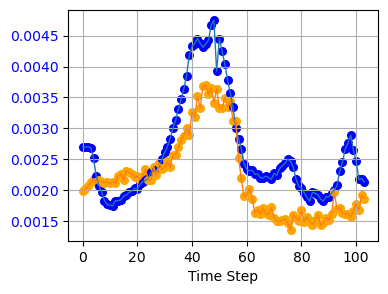

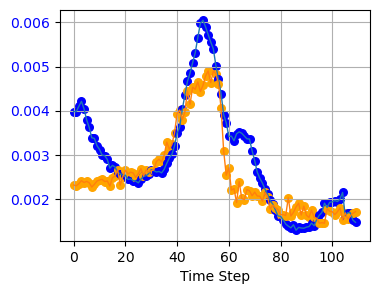

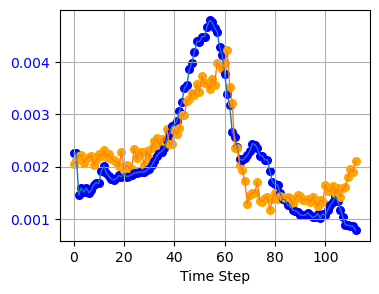

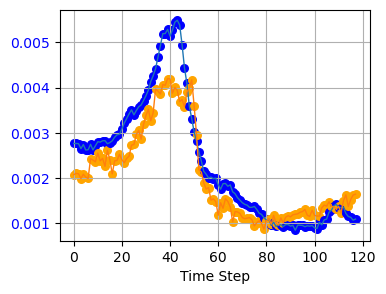

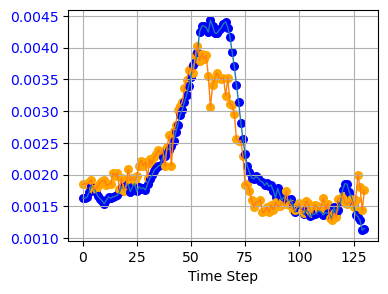

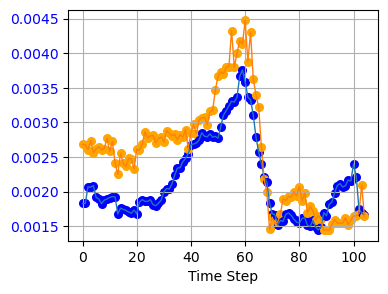

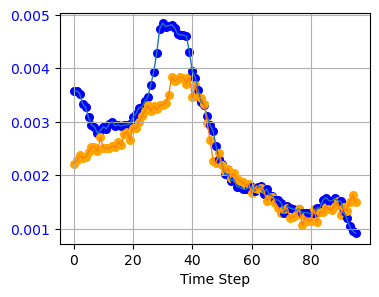

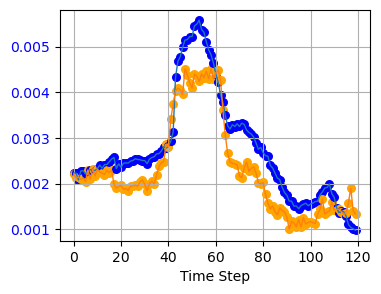

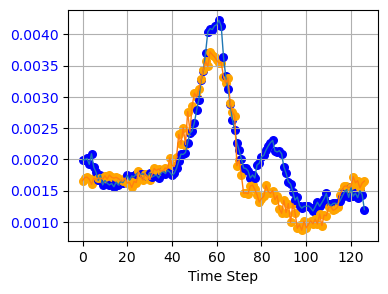

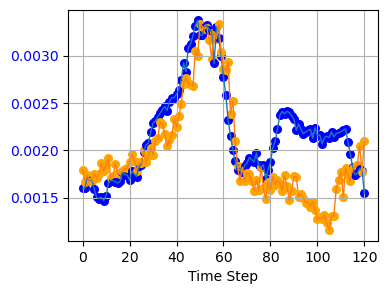

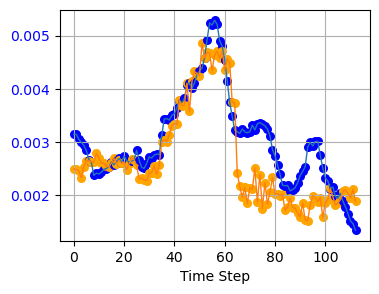

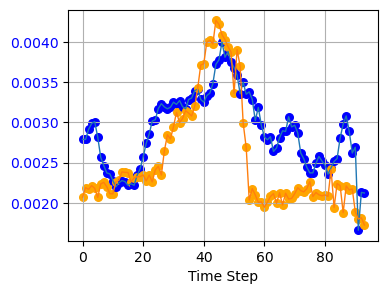

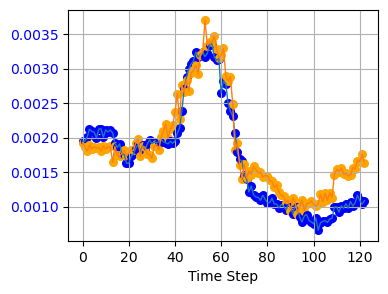

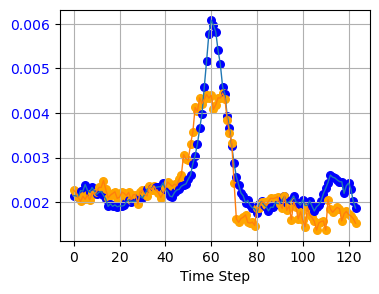

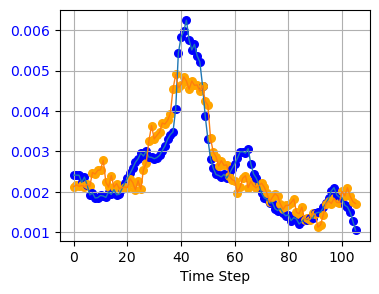

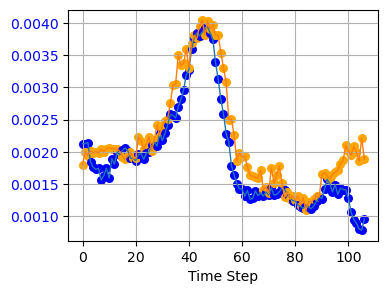

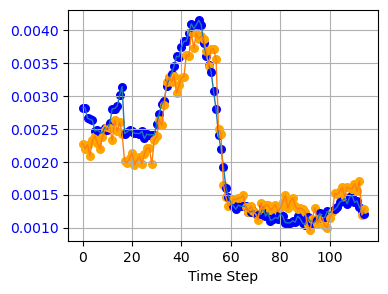

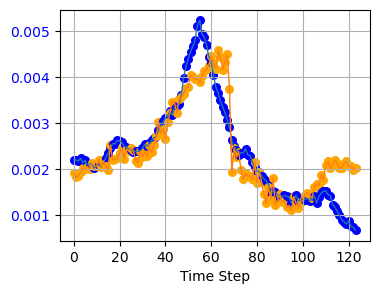

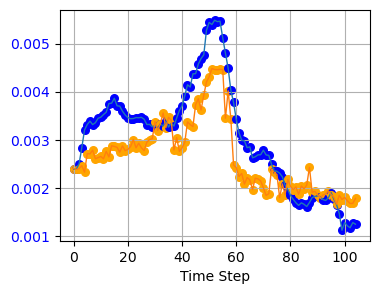

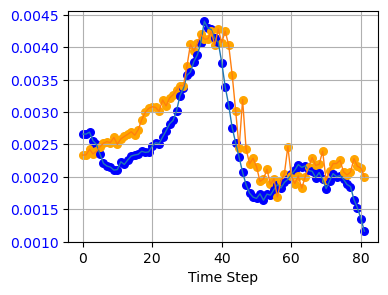

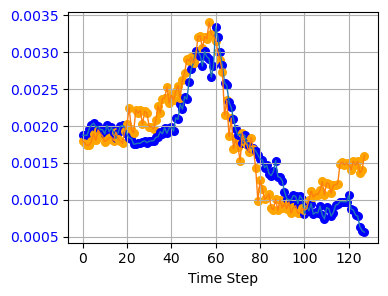

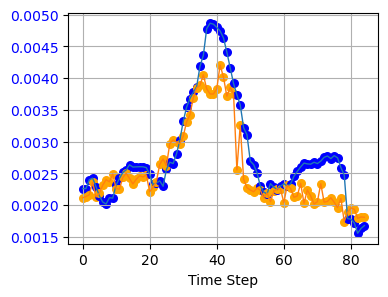

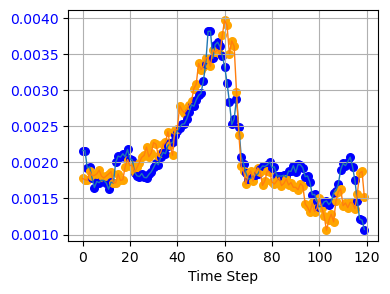

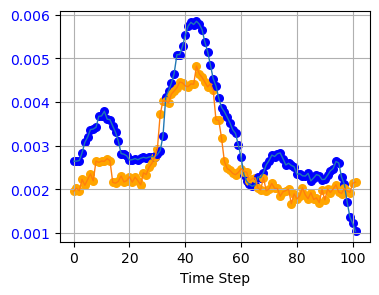

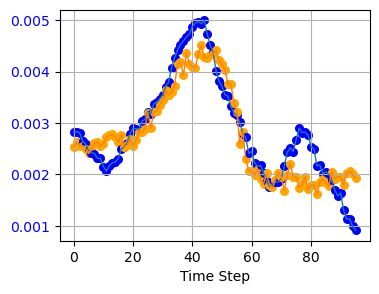

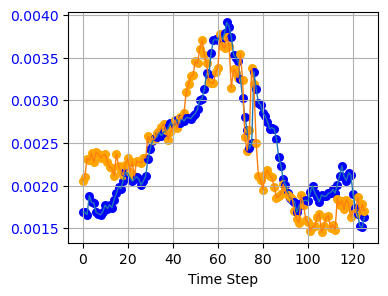

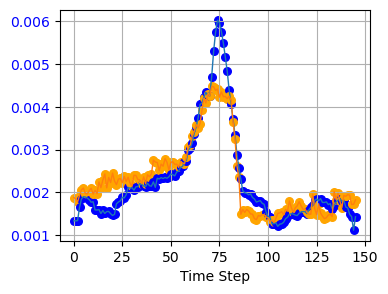

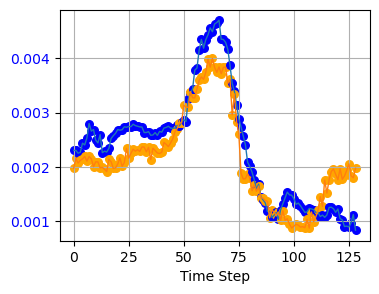

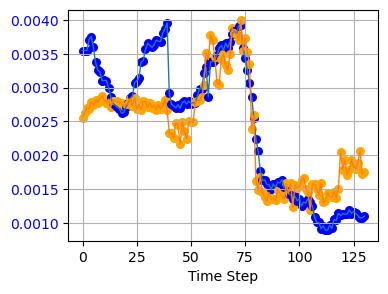

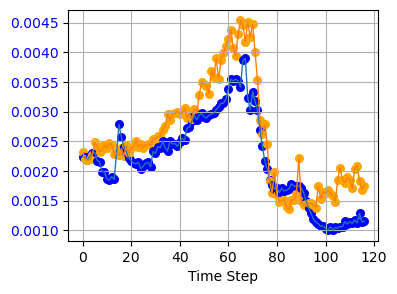

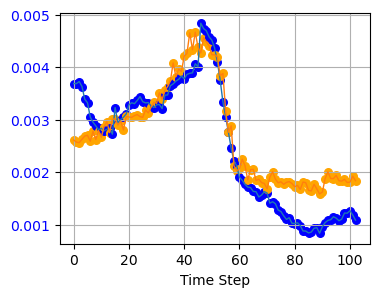

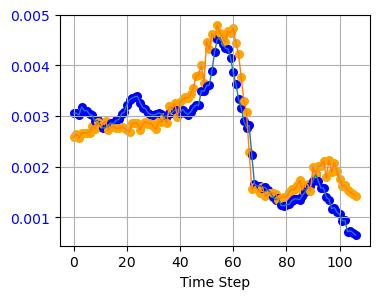

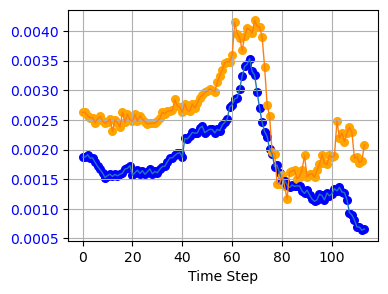

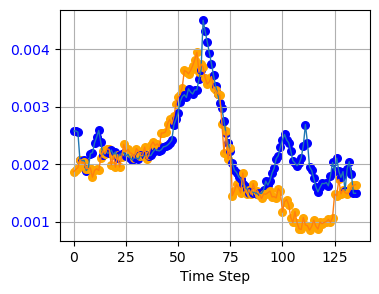

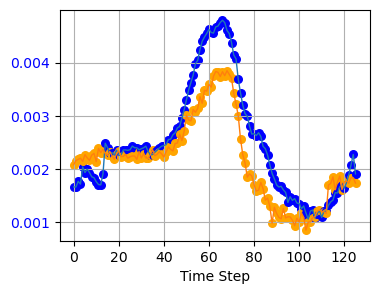

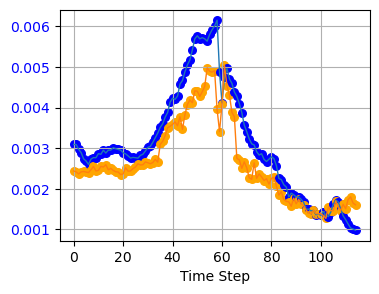

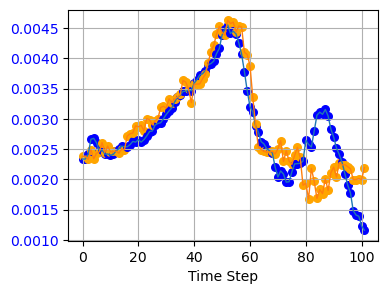

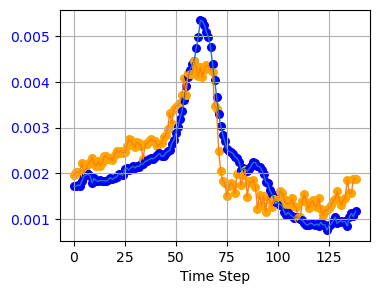

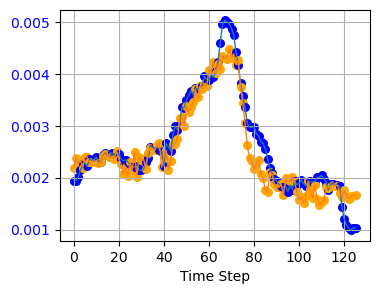

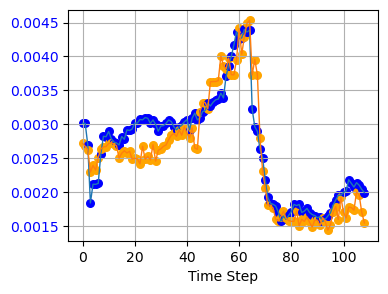

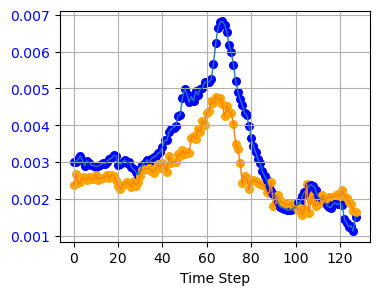

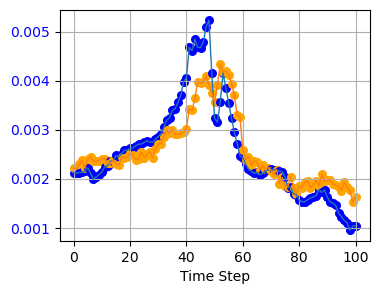

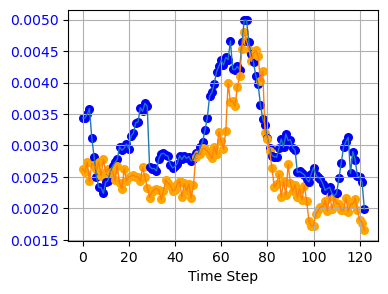

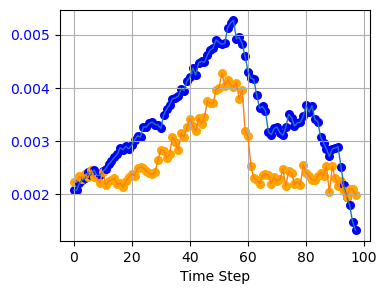

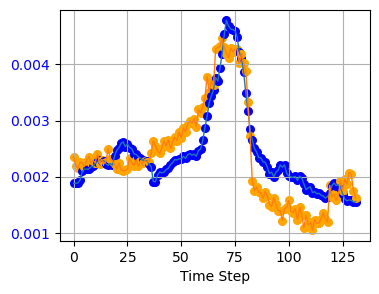

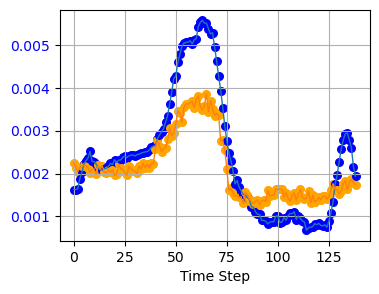

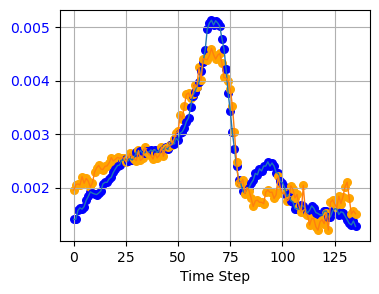

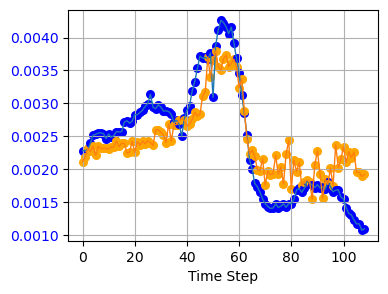

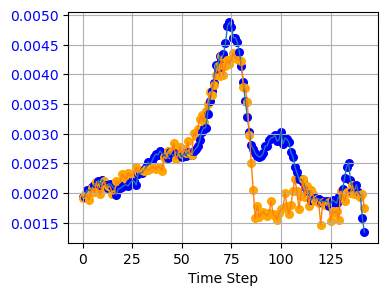

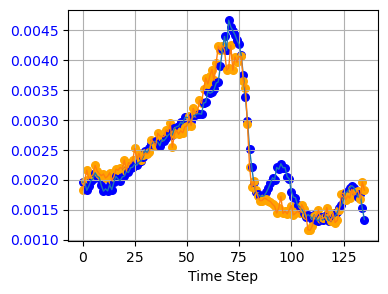

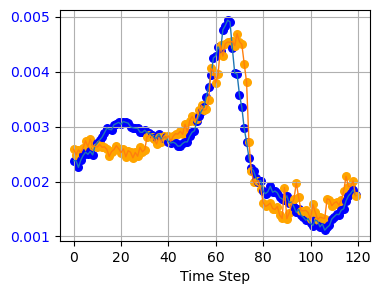

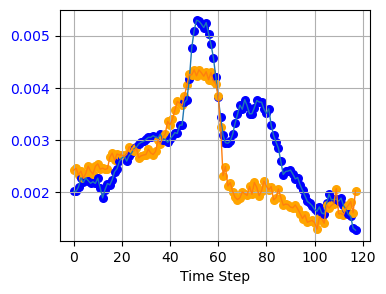

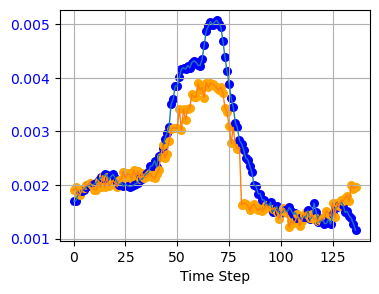

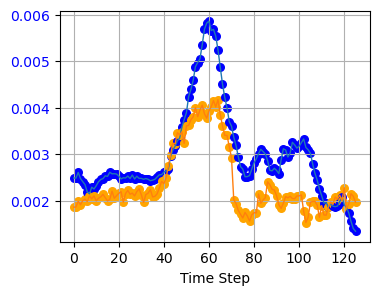

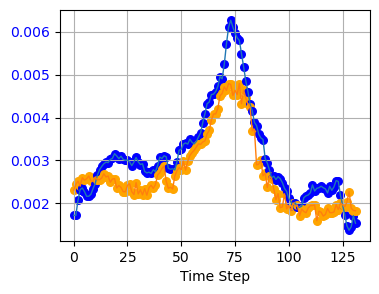

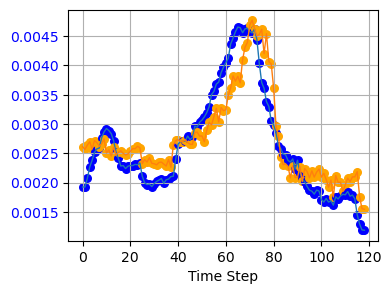

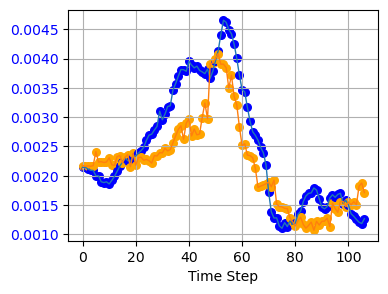

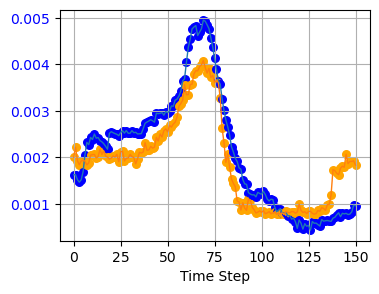

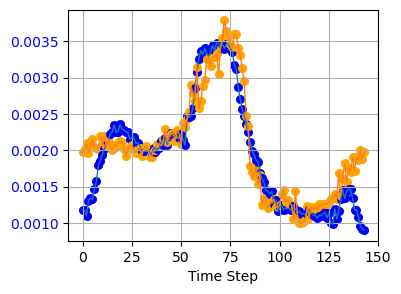

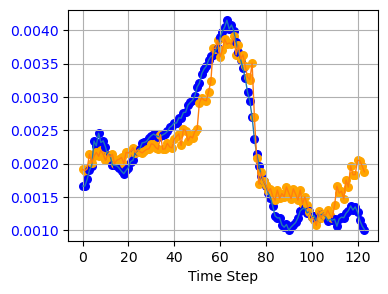

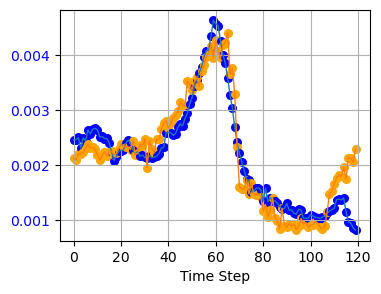

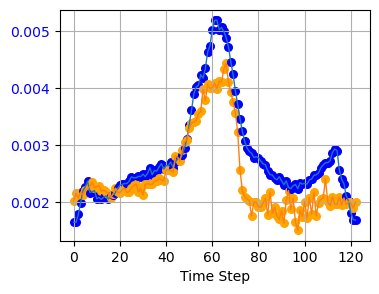

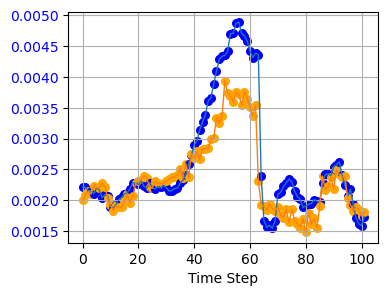

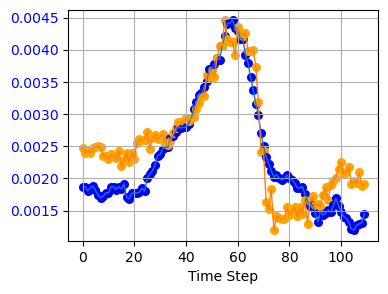

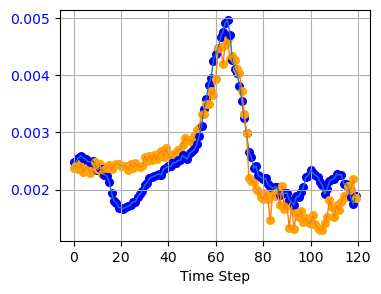

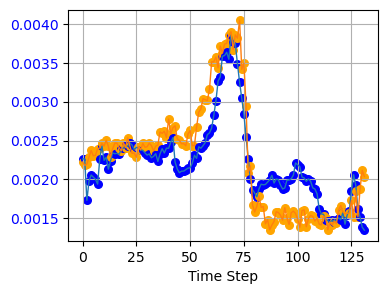

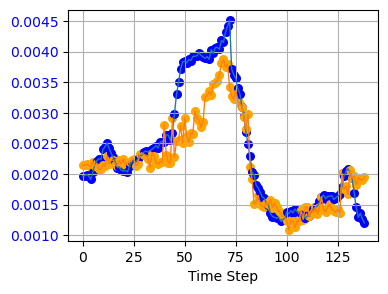

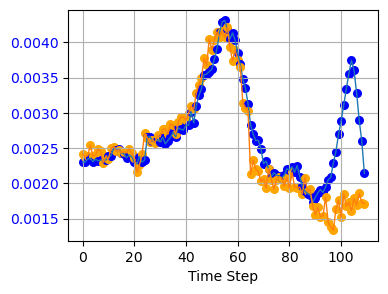

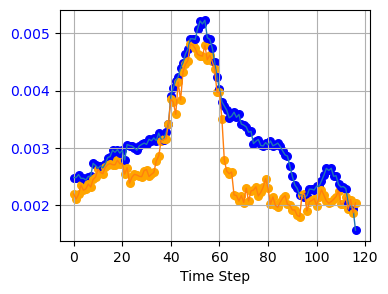

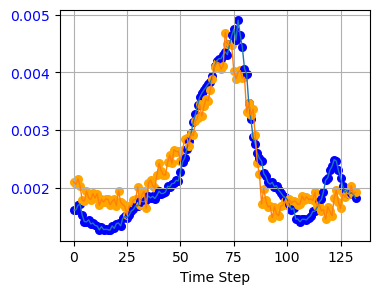

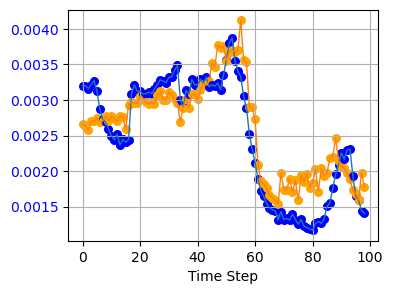

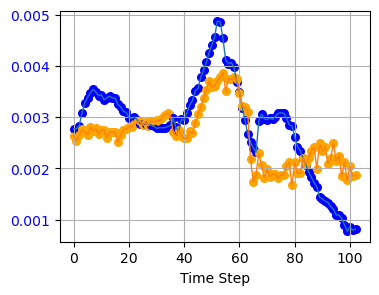

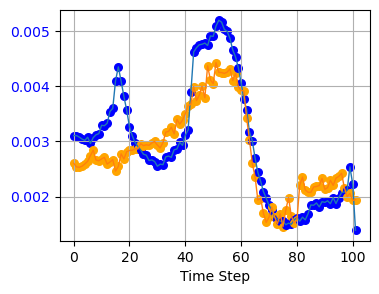

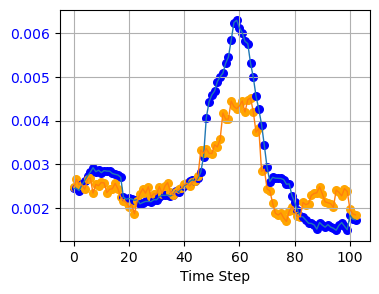

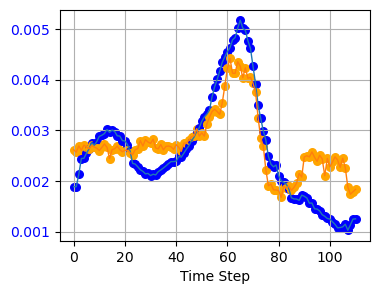

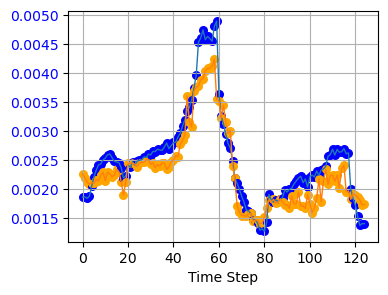

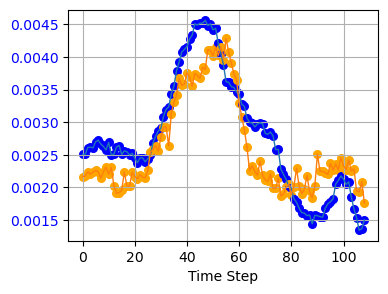

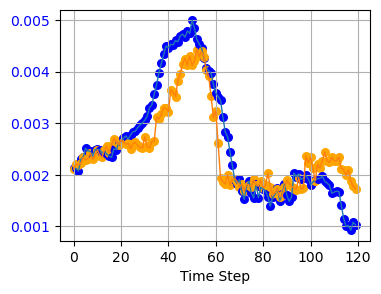

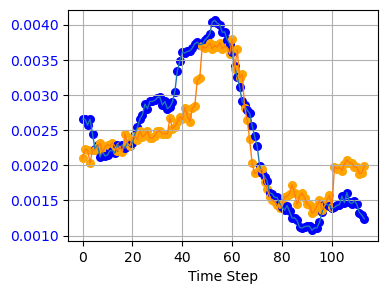

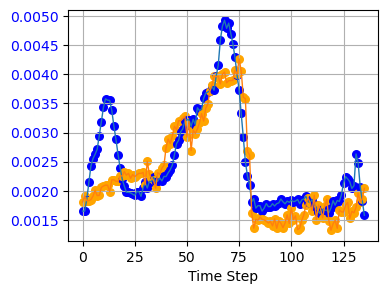

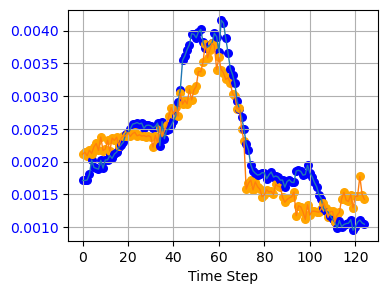

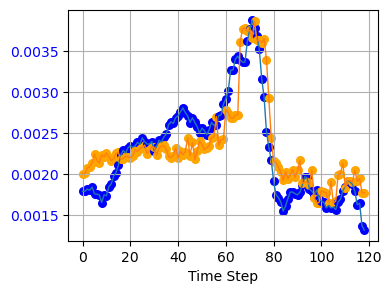

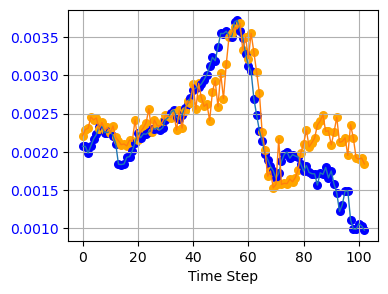

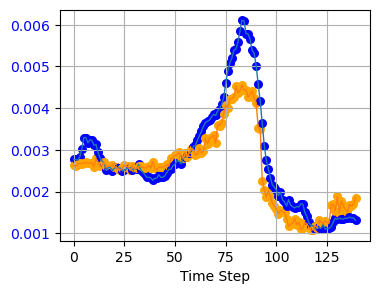

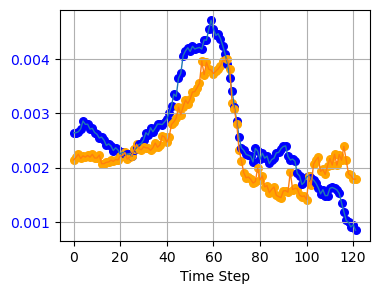

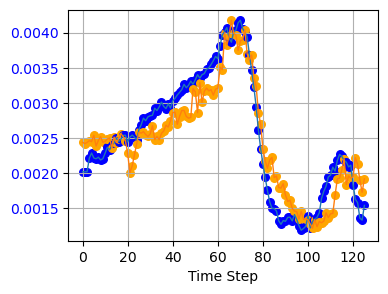

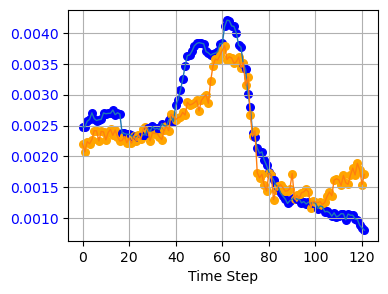

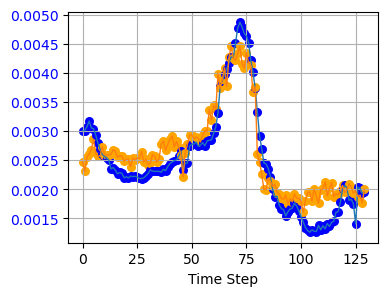

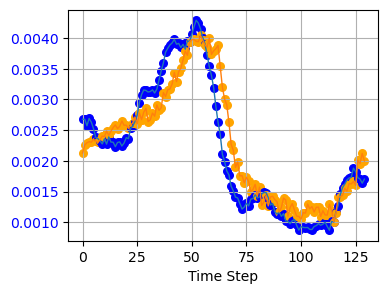

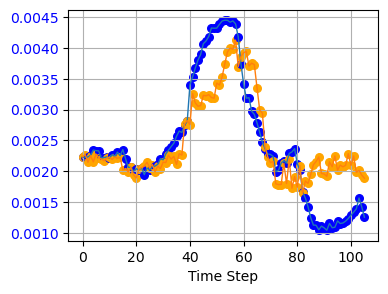

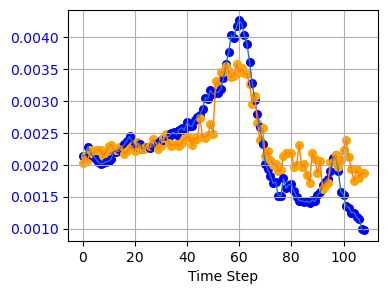

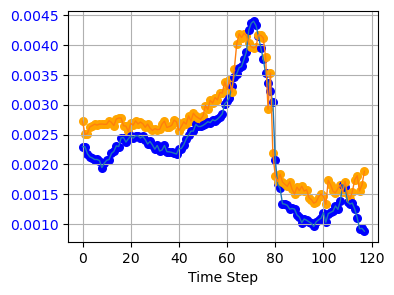

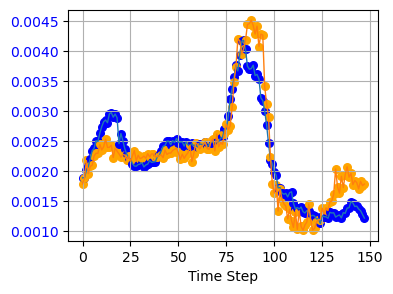

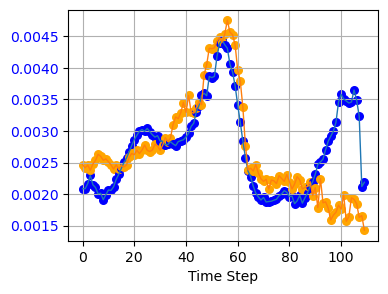

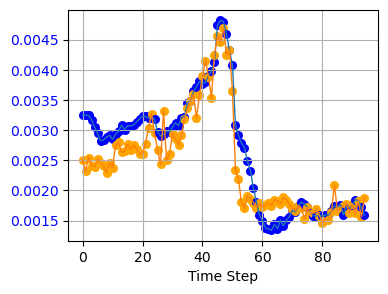

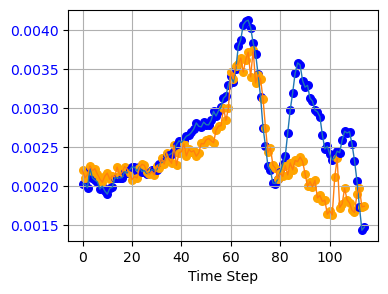

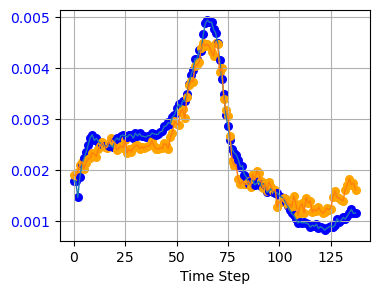

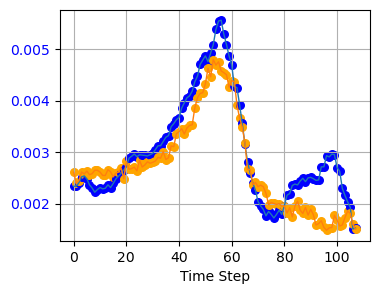

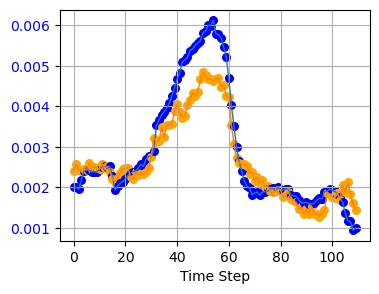

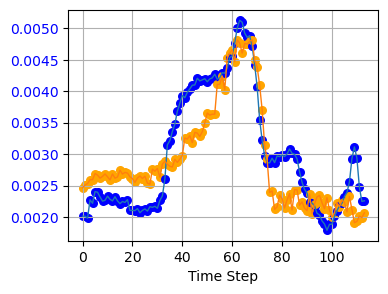

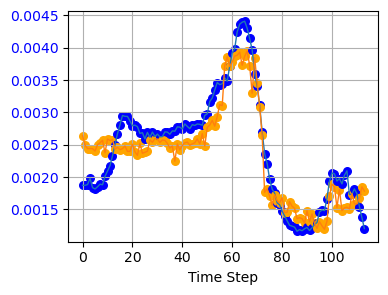

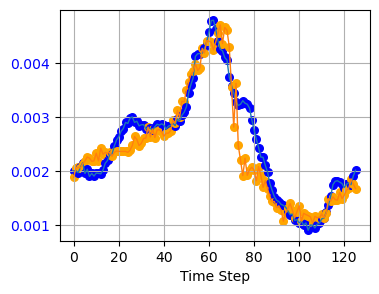

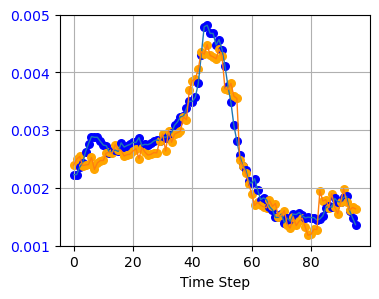

In [13]:
from PIL import Image
import h5py
from tqdm import tqdm
from moviepy.editor import ImageSequenceClip

new_dataset_path = lowdim_dataset_path
file = h5py.File(new_dataset_path, 'r')
num_demos = len(file['data'].keys())

video_dir = os.path.join(lowdim_dataset_dir, f"videos_with_spatial_attention_validate_epoch={dataset_epoch}")
os.makedirs(video_dir, exist_ok=True)

sample = next(iter(img_dataloader))

_, _, C, H, W = sample['obs']['agentview_image'].shape

img_iterator = iter(img_dataloader)
lowdim_iterator = iter(display_dataloader)

for i in tqdm(range(num_demos)):
    demo_key = f'data/demo_{i}'
    demo = file[demo_key]
    num_samples = demo.attrs['num_samples']
    
    imgs = np.zeros((num_samples, H, 2*W, C), dtype=np.uint8)
    
    spatial_attention = list()
    gt_spatial_attention = list()
    for sample_idx in tqdm(range(num_samples), leave=False):        
        sample = next(img_iterator)
        batch = next(lowdim_iterator)
        
        # Transpose from (3,84,84) to (84,84,3) format
        imgs[sample_idx, :, :W, :] = ((sample['obs']['agentview_image'][0, 0].permute(1, 2, 0) * 255).numpy()).astype(np.uint8)
        imgs[sample_idx, :, W:, :] = (sample['obs']['robot0_eye_in_hand_image'][0, 0].permute(1, 2, 0) * 255).numpy().astype(np.uint8)
        
        assert np.linalg.norm(sample['obs']['object'][0, 1, :].numpy()-demo['obs']['object'][sample_idx]) < 1e-4 #check if this is sync well with the dataset
        
        B, T, D = batch['obs'].shape
        nobs = normalizer['obs'].unnormalize(batch['obs']).to(device)
        naction = normalizer['action'].unnormalize(batch['action']).to(device)
        
        obs = nobs[:, :2, :-1].reshape(B, -1).to(device)
        action_seq = naction.to(device)
        attention = nobs[:, :, -1].unsqueeze(-1).to(device)
        
        with torch.no_grad():
            output = model(obs, action_seq).detach()
            attention_pred = normalizer['obs'].normalize(torch.cat([nobs[:, :, :-1], output], dim=-1))[:, :, -1].detach().cpu().numpy()
        spatial_attention.append(attention_pred[0, 0])
        gt_spatial_attention.append(batch['obs'][0, 0, -1])
        
    spatial_attention = np.array(spatial_attention)
    next(img_iterator) # Fro syncing
    next(lowdim_iterator)
            
    # Get attention graph images
    fig, ax = plt.subplots(figsize=(4, 3))
    time_steps = np.arange(len(spatial_attention))
    ax.plot(time_steps, gt_spatial_attention, 'b-', color='tab:blue', linewidth=1, label='Spatial Attention')
    ax.plot(time_steps, spatial_attention, 'b-', color='tab:orange', linewidth=1, label='Spatial Attention')
    ax.set_xlabel('Time Step')
    ax.tick_params(axis='y', labelcolor='b')
    ax.grid(True)
    graph_frames = list()
    for t in range(len(gt_spatial_attention)):
        ax.scatter(t, gt_spatial_attention[t], color='blue', s=30)
        ax.scatter(t, spatial_attention[t], color='orange', s=30)
        
        fig.canvas.draw()
        graph_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        graph_img = graph_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        graph_frames.append(graph_img)
    graph_height, graph_width = graph_frames[0].shape[:2]
    # prepare combined frames
    
    # attention_data = get_spatial_attention_from_episode(epi)
    combined_frames = list()
    for frame, graph in zip(imgs, graph_frames):
        # Resize frame to match graph height
        frame_height, frame_width = frame.shape[:2]
        aspect_ratio = frame_width / frame_height
        new_height = graph_height
        new_width = int(new_height * aspect_ratio)
        
        frame_resized = np.array(Image.fromarray(frame).resize((new_width, new_height)))
        
        # Create canvas and center the frame
        canvas = np.zeros((graph_height, graph_width+new_width, 3), dtype=np.uint8)
        
        canvas[:, :new_width, :] = frame_resized
        canvas[:, new_width:, :] = graph
        combined_frames.append(canvas)
        
    video_path = os.path.join(video_dir, f"episode_{i}.mp4")
    
    # Create and write video with moviepy
    clip = ImageSequenceClip(combined_frames, fps=10)
    clip.write_videofile(video_path, codec='libx264')